# Base DCGAN

In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## Pre-Processing & EDA

In [43]:
# load CIFAR10 dataset
(X_train, y_labels), (X_test, y_test) = load_data()

X_train = np.concatenate((X_train, X_test), axis=0)
y_labels = np.concatenate((y_labels, y_test), axis=0)

# load and prepare cifar10 training images
def load_real_normalized_samples(features):
	# convert from unsigned ints to floats
	X = features.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

# load image data
dataset = load_real_normalized_samples(X_train)

In [35]:
y_labels.shape
X_train.shape

(50000, 32, 32, 3)

In [44]:
# Labels in order
labels = [ "airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck" ]

# flip horizontally
# rotation 20-30

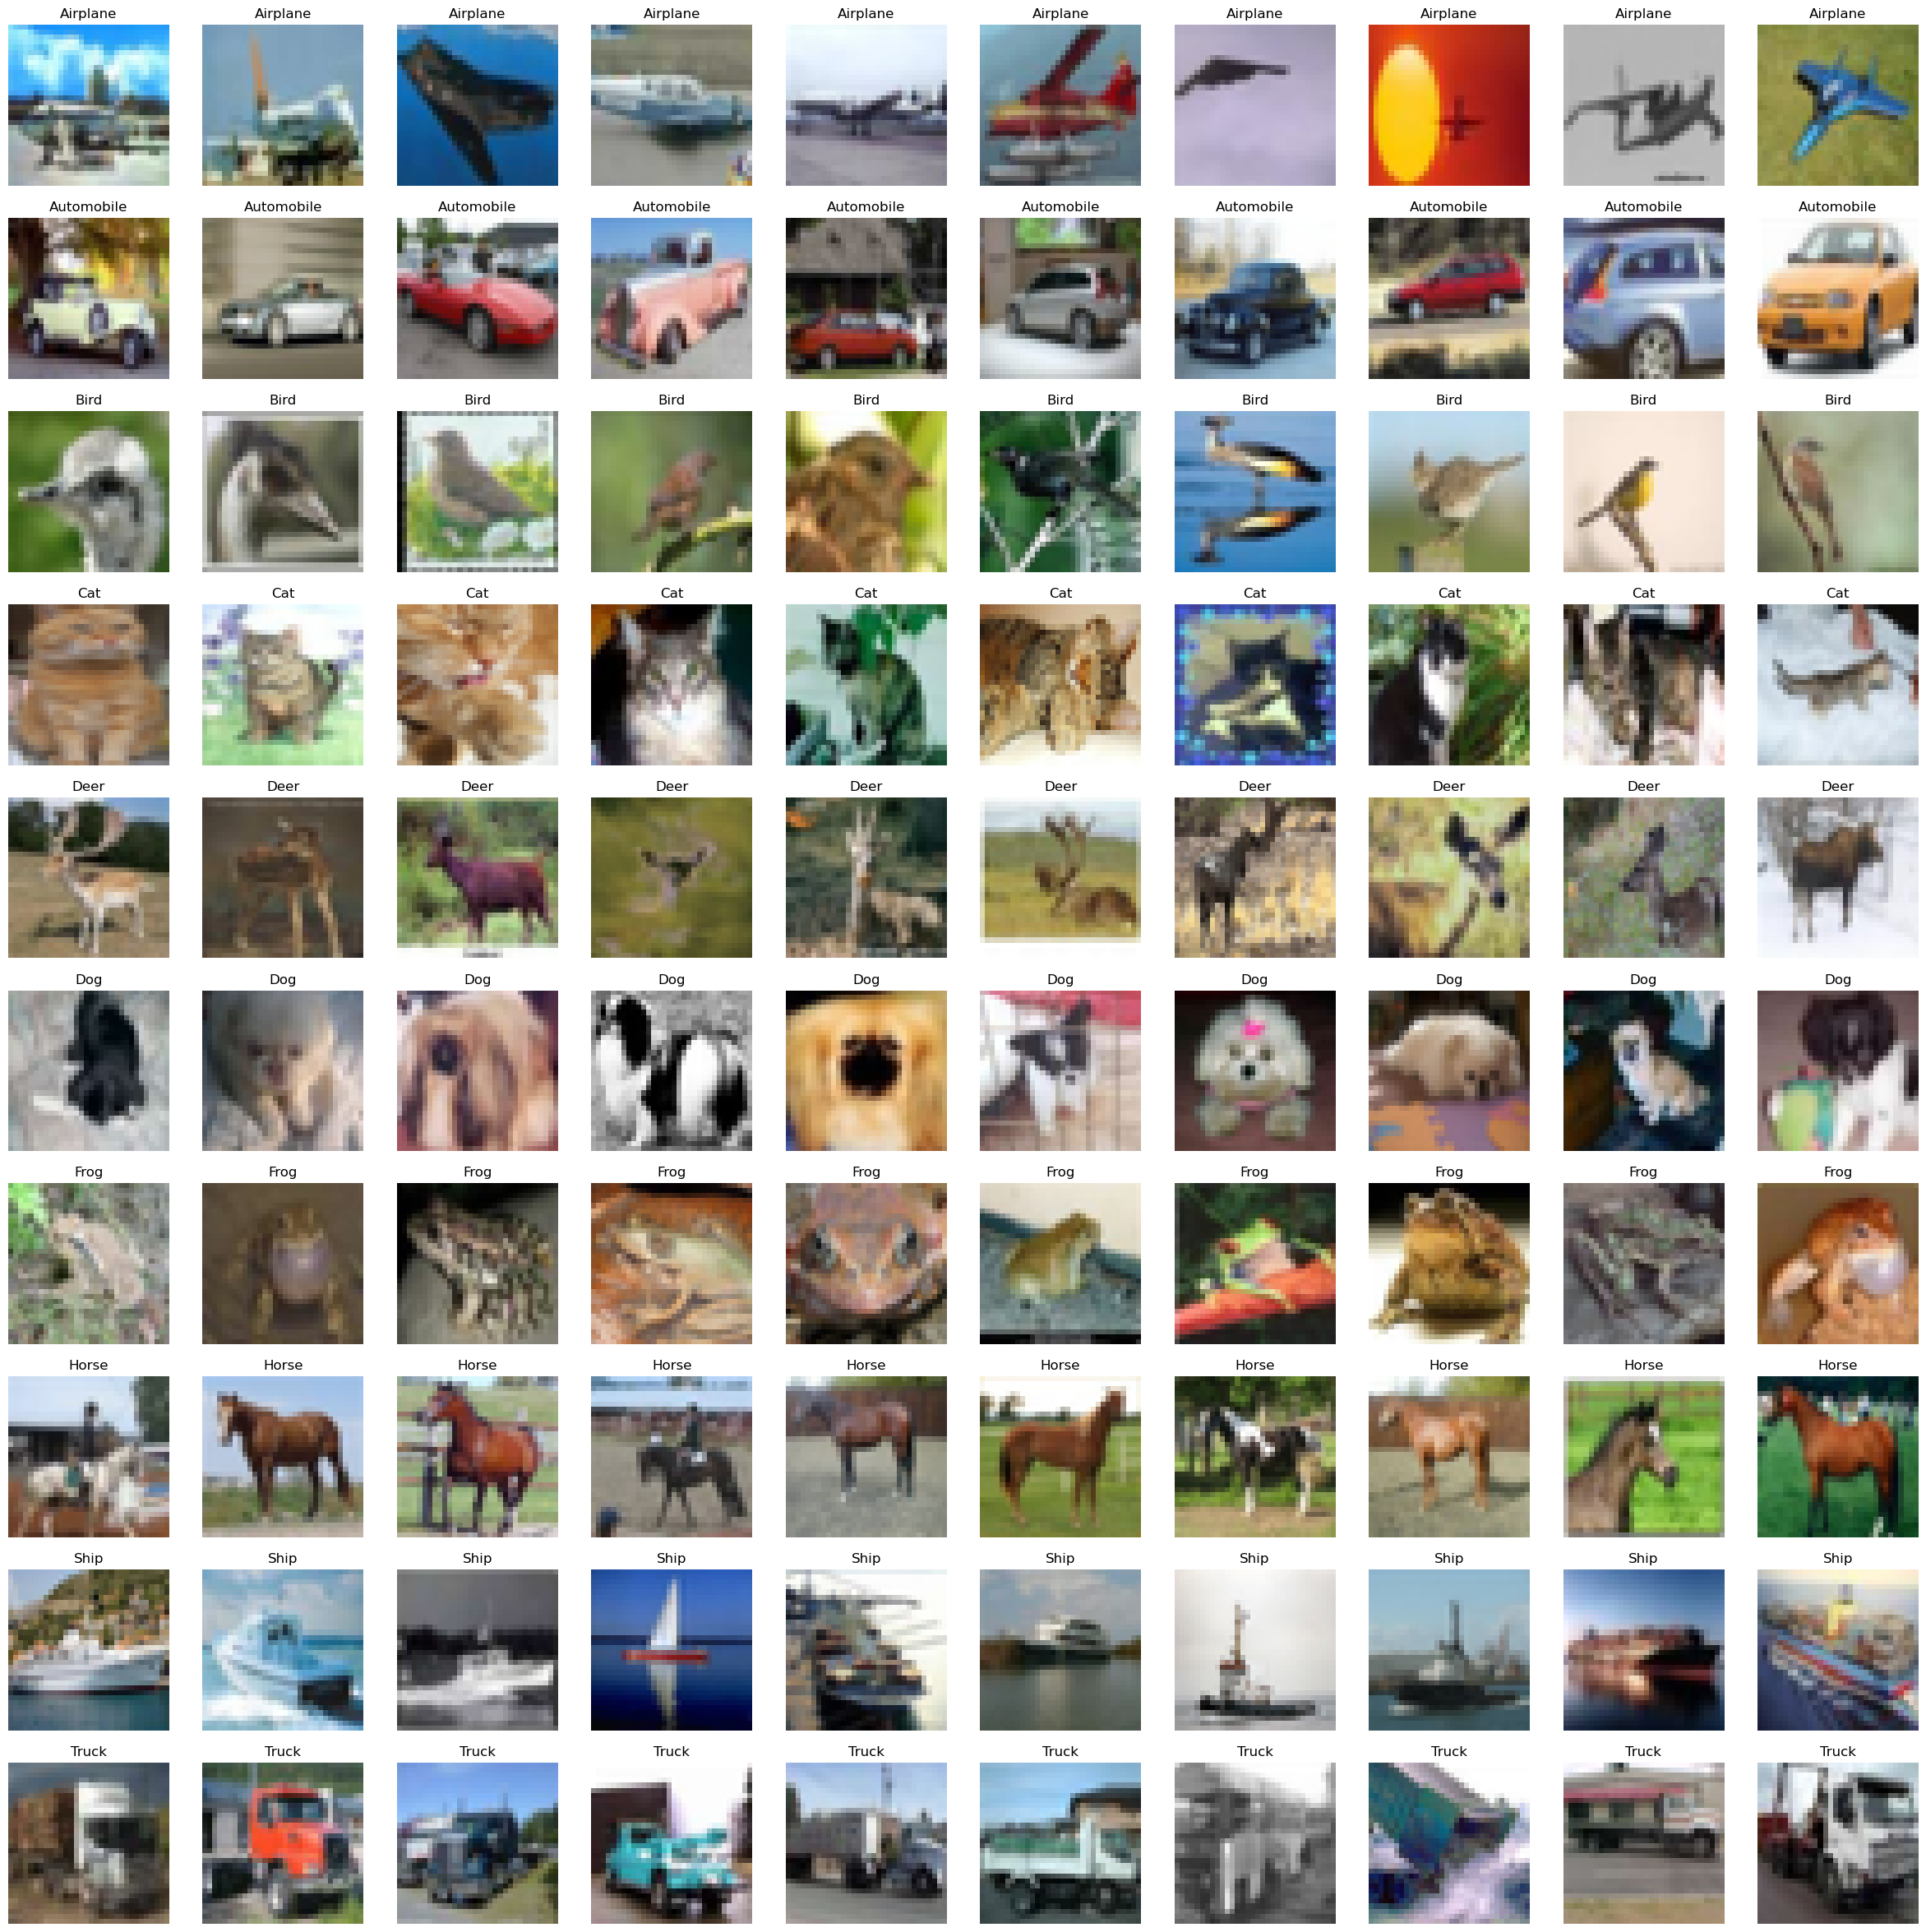

In [36]:
import numpy as np
class_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

NUM_CLASS = 10

# show sample unnormalized images
fig, ax = plt.subplots(10, 10, figsize=(30, 30))
for i in range(10):
    images = X_train[np.squeeze(y_labels == i)]
    random_index = np.random.choice(images.shape[0], 10, replace=False)
    images = images[random_index]
    label = class_labels[i]
    for j in range(10):
        subplot = ax[i, j]
        subplot.axis("off")
        subplot.imshow(images[j])
        subplot.set_title(label)

plt.show()

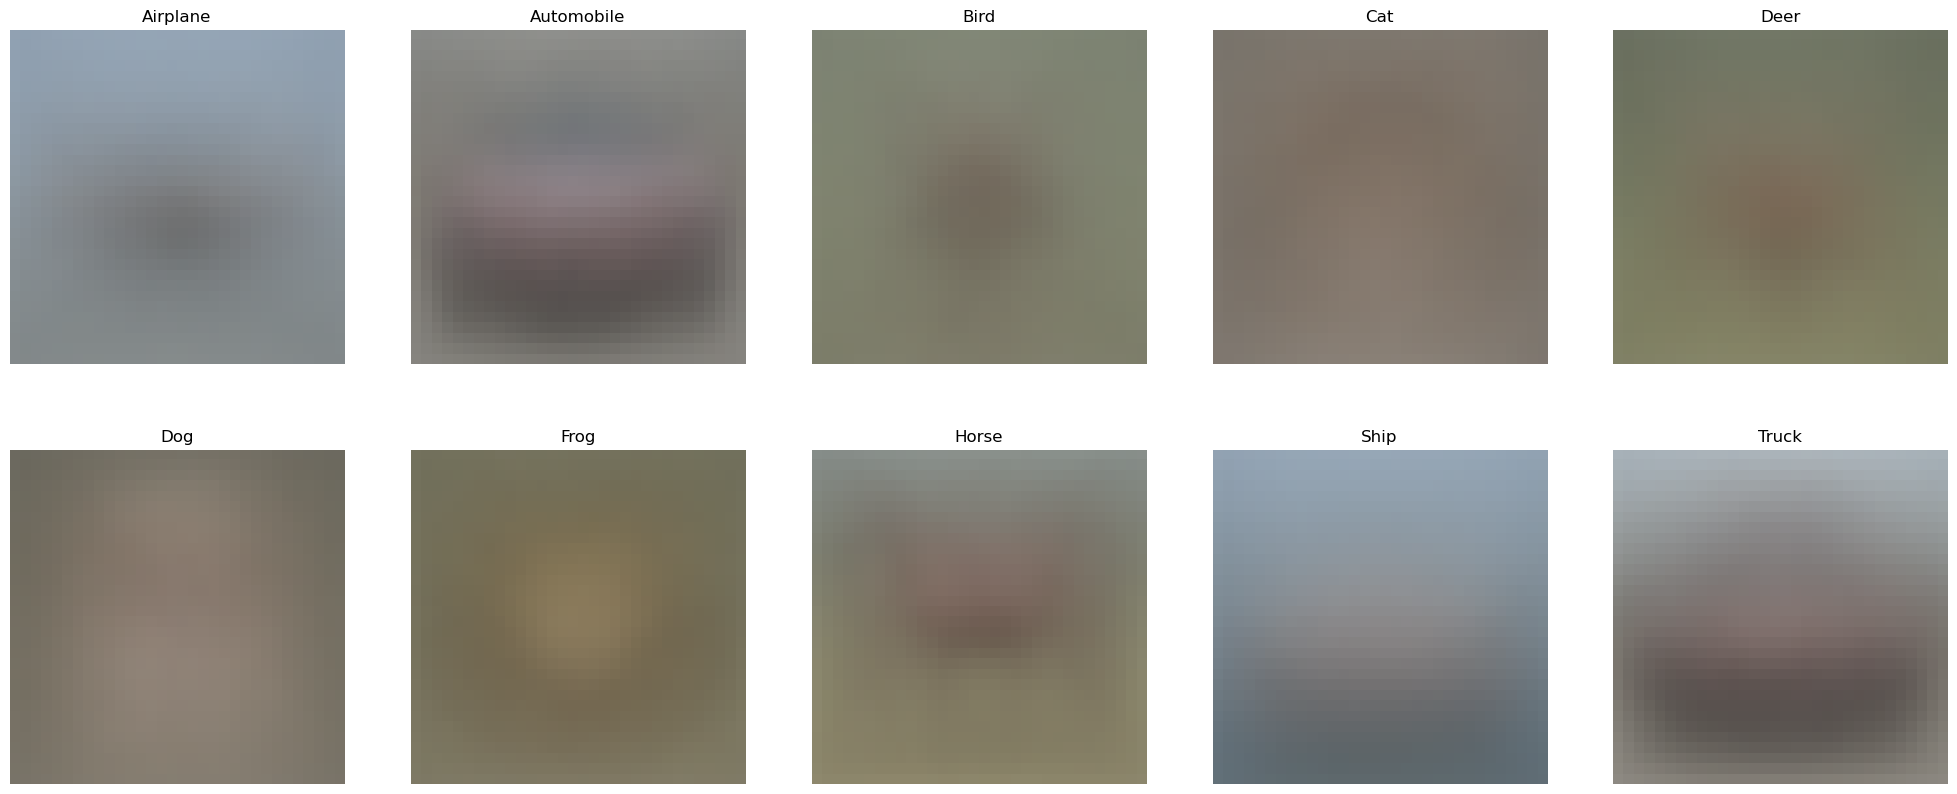

In [45]:
# pixel averaging
fig, ax = plt.subplots(2, 5, figsize=(25, 10))

for idx, subplot in enumerate(ax.ravel()):
    avg_image = np.mean(X_train[np.squeeze(y_labels == idx)], axis=0) / 255
    subplot.imshow(avg_image)
    subplot.set_title(f"{class_labels[idx]}")
    subplot.axis("off")

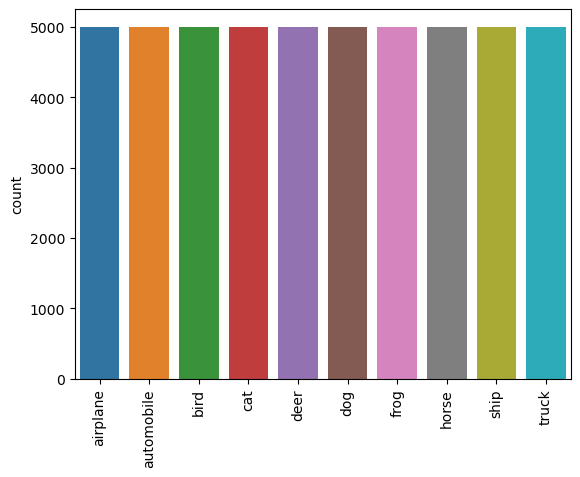

In [41]:
import pandas as pd
import seaborn as sns
df_eda = pd.DataFrame(y_labels, columns=['label'])
df_eda.value_counts()
plt.xticks(rotation=90)
sns.barplot(x=labels, y = df_eda.value_counts())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

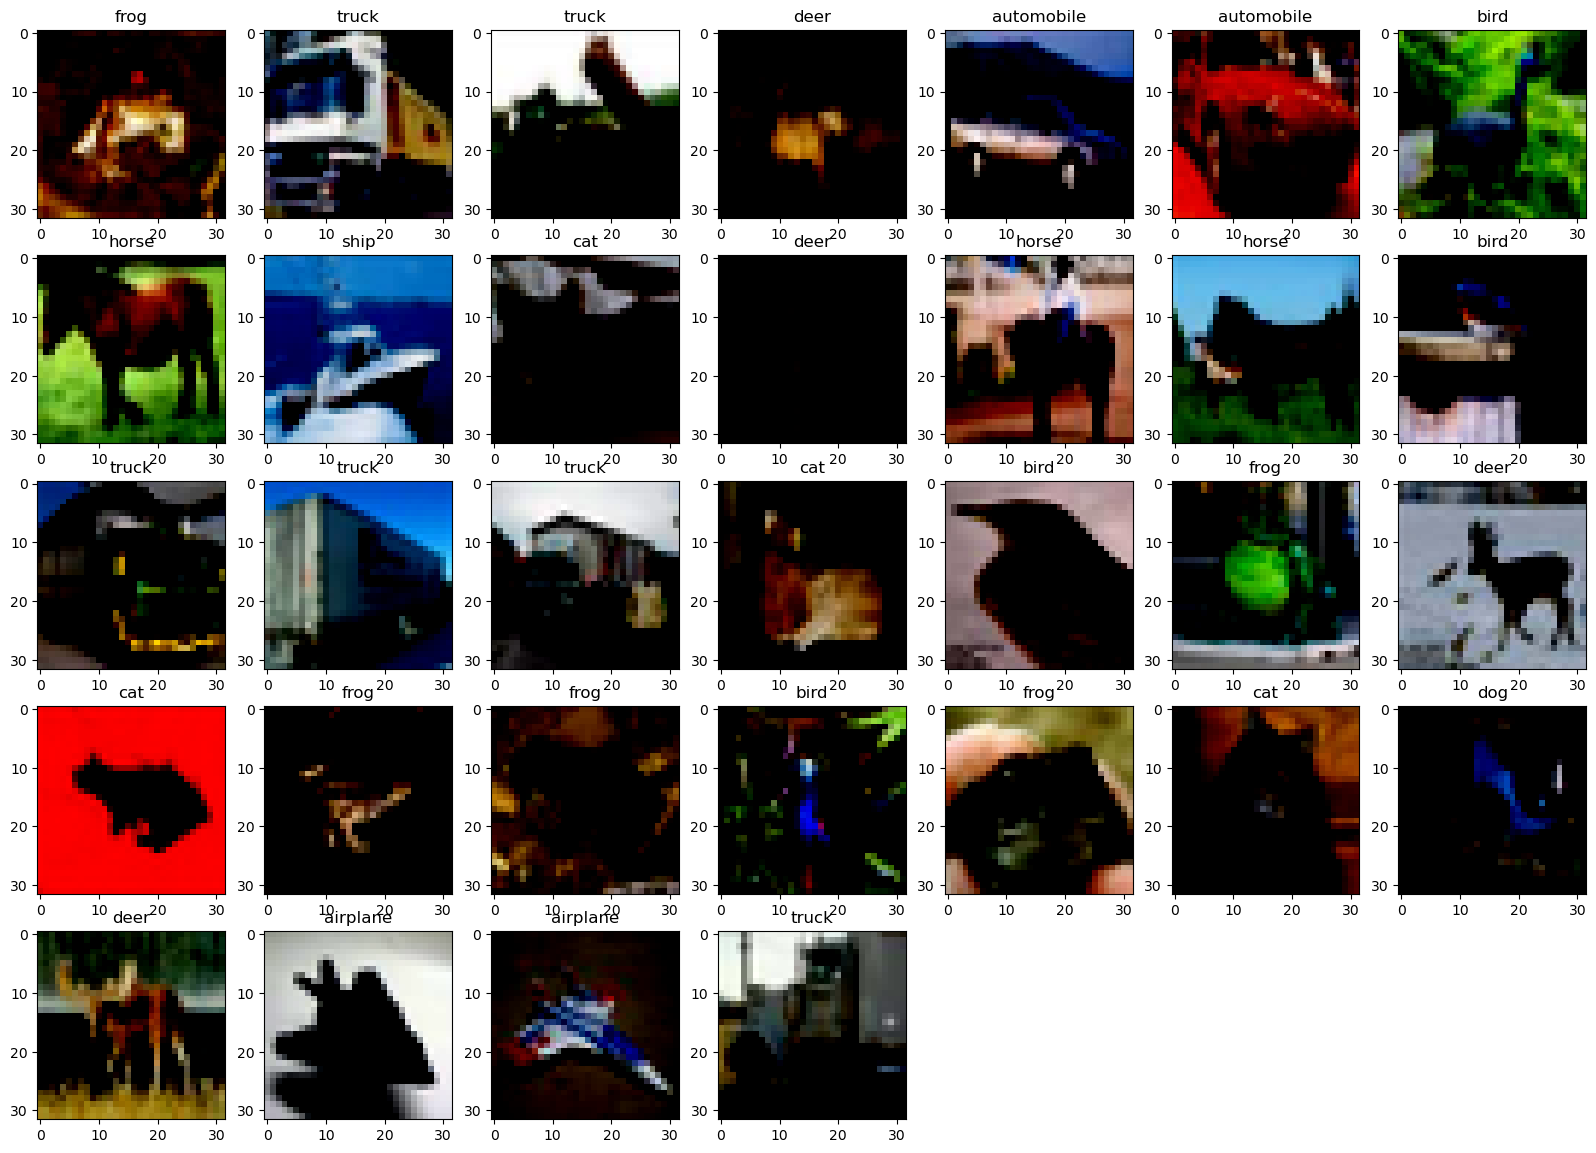

In [14]:
# Show normalized images
fig = plt.figure(0)
fig.set_size_inches(20, 20)
for i in range(0,32):
    fig.add_subplot(7, 7, i+1)
    plt.imshow(dataset[i])
    plt.title("{}".format(labels[int(y_labels[i])]))

## Data Augmentation

In [39]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
])

X_train_aug = data_augmentation(X_train)
X_train = np.concatenate((X_train, X_train_aug), axis=0)

In [ ]:
y_labels = np.concatenate((y_labels, y_labels), axis=0)

In [40]:
X_train.shape

(100000, 32, 32, 3)

## Build Model


In [15]:
# define the standalone discriminator model
def define_discriminator(input_shape=(32,32,3), lr=0.0002):
	model = Sequential()
	# normal
	model.add(Conv2D(64, (3,3), padding='same', input_shape=input_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	#maybe put another dense
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=lr, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model 

## Tune Disciminator - Learning Rate, Conv Layers, Dense Layers.

In [16]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 4x4 image
	n_nodes = 256 * 4 * 4
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((4, 4, 256)))
	# upsample to 8x8
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# output layer
	model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
	return model


## Tune numuber of layers and nodes, learning rate, alpha

In [17]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, lr=0.0002):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=lr, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [18]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [19]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [20]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [5]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i])
	# save plot to file
	filename = 'CIFAR_imgs/generated_plot_e%03d.png' % (epoch+1)
	plt.savefig(filename)
	plt.close()


In [22]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy Real Image: %.0f%%, Fake Image: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(X_fake, epoch)
	# save the generator model weight file
	filename = 'CIFAR_weights/generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

## Train

In [23]:
# train the generator and discriminator
def train(generator, discriminator, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
	batches_per_epoch = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(batches_per_epoch):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			discriminator_loss1, _ = discriminator.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)
			# update discriminator model weights
			discriminator_loss2, _ = discriminator.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)

			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			
			# update the generator via the discriminator's error
			generator_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, discriminator loss 1 : %.3f, discriminator loss 2 : %.3f generator loss : %.3f' %
				(i+1, j+1, batches_per_epoch, discriminator_loss1, discriminator_loss2, generator_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, generator, discriminator, dataset, latent_dim)

In [ ]:
# size of the latent space
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

## Load Model



4/4 [==============================] - 0s 17ms/step


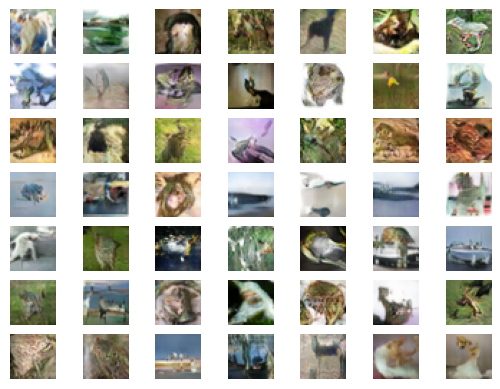

In [3]:
from tensorflow.keras.models import load_model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	X_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	X_input = X_input.reshape(n_samples, latent_dim)
	return X_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :])
	plt.show()

# load model
model = load_model('./CIFAR_weights/generator_model_200.h5')
# generate images
latent_points = generate_latent_points(100, 100)

# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 7)

In [13]:
### Generate 1000 images
latent_points = generate_latent_points(100, 1024)
X = model.predict(latent_points)
X = (X + 1) / 2.0
save_plot(X, 1, 32)

 1/32 [..............................] - ETA: 1s

32/32 [==============================] - 1s 24ms/step


## Inception Score

In [4]:
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		# subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
# 		subset = preprocess_input(subset)
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std		

In [11]:
latent_points = generate_latent_points(100, 5000)
# generate images
X = model.predict(latent_points)

# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# calculate inception score
is_avg, is_std = calculate_inception_score(X)
print('score', is_avg, is_std)

1/1 [==============================] - 1s 583ms/step
score 3.2336814 0.3711945


# Conditional DCGAN with label smoothing on CIFAR-10 dataset

Here we will implement a conditional DCGAN with label smoothing on the CIFAR-10 dataset.

Label smoothing for GANs was described in : https://arxiv.org/abs/1606.03498

This implementation requires **Tensorflow 2.0**. The first few cells are only related to Google Colab and Google Drive, you can ignore them.

## Imports, helper functions and preliminaries

Importing the libraries

In [4]:
# Coding
import tensorflow as tf 
from tensorflow.keras import layers
import numpy as np

# Plotting and manipulating images
import matplotlib.pyplot as plt
import glob
import PIL
from IPython import display

# Timing
import datetime
import time

# Managing the folders 
import os
import shutil

Creating the folders

In [5]:
# Removing the old images generated during training

NAME_FILE = "Label smoothing"

rm_path = "." + os.sep + NAME_FILE + os.sep + "new_imgs"
if os.path.exists(rm_path):
    shutil.rmtree(rm_path)

# Creating folders to save images, models and checkpoints
newpaths = ["." + os.sep + NAME_FILE + os.sep + "new_imgs", 
            "." + os.sep + NAME_FILE + os.sep + "new_models",
            "." + os.sep + NAME_FILE + os.sep + "new_losses"]
for newpath in newpaths:
    if not os.path.exists(newpath):
        os.makedirs(newpath)

Helper functions

In [6]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
NUM_CLASSES = len(CLASSES)

def generate_and_save_images(model,
                             epoch,
                             test_input,
                             g_loss,
                             d_loss,
                             conditions=None,
                             x_axis="scale",
                             y_max=5,
                             save=True):

  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    if conditions is not None:
        predictions = model([test_input, conditions], training=False)
    else:
        predictions = model([test_input], training=False)

    fig = plt.figure(figsize=(20,8))
    outer = gridspec.GridSpec(1, 2, wspace=0.2, hspace=0.2)

    inner_im = gridspec.GridSpecFromSubplotSpec(4, 5,
                  subplot_spec=outer[0], wspace=0.1, hspace=0.1)

    for i in range(predictions.shape[0]):
        ax = plt.Subplot(fig, inner_im[i])
        ax.imshow((predictions[i]+1) / 2 )
        if conditions is not None:
            ax.title.set_text(CLASSES[np.argmax(conditions[i])])
        ax.axis('off')
        fig.add_subplot(ax)
    
    if save:
        fig.savefig("." + os.sep + NAME_FILE + os.sep + 'imgs' + os.sep + 'image_at_epoch_{:04d}.png'.format(epoch), bbox_inches="tight")
    
    
    inner_l = gridspec.GridSpecFromSubplotSpec(1, 1,
                  subplot_spec=outer[1], wspace=0.1, hspace=0.1)
    
    ax1 = plt.Subplot(fig, inner_l[0])
    
    samples = 1000
    g_losses_sampled = []
    d_losses_sampled = []
    xs = []

    for i in range(len(g_loss) // samples):
        g_losses_sampled.append(np.mean(g_loss[i*samples:(i+1)*samples]))
        d_losses_sampled.append(np.mean(d_loss[i*samples:(i+1)*samples]))
        xs.append(i*samples + samples/2)

    ax1.plot(xs, g_losses_sampled, "r-")
    ax1.plot(xs, d_losses_sampled, "b-")

    red_patch = mpatches.Patch(color='red', label='Generator loss')
    blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
    ax1.legend(handles=[red_patch,blue_patch])
    
    if x_axis == "total":
        ax1.set_xlim([0, train_images.shape[0]//BATCH_SIZE * EPOCHS])
    else:
        ax1.set_xlim([0, xs[-1] + xs[-1]*0.1])
    ax1.set_ylim([0, y_max])
    
    
    
    fig.add_subplot(ax1)
    
    plt.show()


## Hyperparameters

In [7]:
# Training parameters
EPOCHS =         100
BATCH_SIZE =     128       # Amount of images processed before backpropagating

# Models parameters
NOISE_DIM =      100      # Amount of features for the generator
KERNEL_SIZE =    (3, 3)   # Kernel size for the convolutional layers
MOMENTUM =       0.9      # Momentum for the batch normalization layers
DROPOUT =        0.2      # Dropout rate
ALPHA =          0.2      # Alpha for the leaky ReLU slope

# Optimizer parameters
LEARNING_RATE =  0.0001     # Learning rate for the Adam Optimizer
BETA_1 =         0.5      # Beta_1 for the Adam Optimizer
BETA_2 =         0.9      # Beta_2 for the Adam Optimizer

# Display parameters
NUM_EXAMPLES =   20       # Amount of examples to generate

## Data loading and preprocessing

Loading and preprocessing the dataset. We will use CIFAR-10.

In [8]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomCrop(32,32),
])

train_images_aug = data_augmentation(train_images)
train_images = np.concatenate((train_images, train_images_aug), axis=0)


if train_images.shape[0] > 50000:
    train_labels = np.concatenate((train_labels, train_labels), axis=0)
    
# Shape of the training dataset
IMAGE_SIZE =     train_images.shape[-2] # Size of the images of the training dataset (width and height)
IMAGE_CHANNELS = train_images.shape[-1] # Amount of channels of the training dataset (depth)

# Preprocessing the dataset
train_images = train_images.reshape(train_images.shape[0], IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_labels = tf.one_hot(train_labels, NUM_CLASSES)
train_labels = tf.reshape(train_labels, (train_labels.shape[0], train_labels.shape[2]))

## Network Architecture

In this section, we will detail what architectures are used for training the conditional DCGAN.

**For our generator, we will use the following architecture :**

In [9]:
# Constructing the conditional generator

def generator_model(input_layer, condition_layer, verbose=False):
    
    # Constrain the generator with a condition
    merged_in = layers.Concatenate()([input_layer, condition_layer])

    hid = layers.Dense(512 * 2 * 2)(merged_in)
    hid = layers.Reshape((2, 2, 512))(hid)
    hid = layers.ReLU()(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    # 2 ==> 4
    hid = layers.Conv2DTranspose(   512, kernel_size=KERNEL_SIZE, strides=(2, 2), padding="same", use_bias=False)(hid)
    hid = layers.ReLU()(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    # 4 ==> 8
    hid = layers.Conv2DTranspose(   256, kernel_size=KERNEL_SIZE, strides=(2, 2), padding="same", use_bias=False)(hid)
    hid = layers.ReLU()(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    # 8 ==> 16
    hid = layers.Conv2DTranspose(   128, kernel_size=KERNEL_SIZE, strides=(2, 2), padding="same", use_bias=False)(hid)
    hid = layers.ReLU()(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    
    # 16 ==> 32 
    hid = layers.Conv2DTranspose(   64, kernel_size=KERNEL_SIZE, strides=(2, 2), padding="same", use_bias=False)(hid)
    hid = layers.ReLU()(hid)
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)
    

       
    hid = layers.Conv2D(IMAGE_CHANNELS, kernel_size=KERNEL_SIZE, strides=(1, 1), padding="same")(hid)
    out = layers.Activation("tanh")(hid)

    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    
    if verbose:
        model.summary()
    
    return model

**For our discriminator, we will use the following architecture :**

In [10]:
def discriminator_model(input_layer, condition_layer, verbose=False):

    # 32 ==> 16
    hid = layers.Conv2D(64,  kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', use_bias=False)(input_layer) 
    hid = layers.LeakyReLU(alpha=ALPHA)(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)

    # 16 ==> 8
    hid = layers.Conv2D(128, kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', use_bias=False)(hid)
    hid = layers.LeakyReLU(alpha=ALPHA)(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)

    # 8 ==> 4
    hid = layers.Conv2D(256, kernel_size=KERNEL_SIZE, strides=(2, 2), padding='same', use_bias=False)(hid)
    hid = layers.LeakyReLU(alpha=ALPHA)(hid) 
    hid = layers.BatchNormalization(momentum=MOMENTUM)(hid)

    hid = layers.Flatten()(hid)

    hid = layers.Dropout(0.4)(hid)
    # Indicating the discriminator the condition
    merged = layers.Concatenate()([hid, condition_layer])
    
    hid =    layers.Dense(256)(merged)
    hid =    layers.LeakyReLU(alpha=ALPHA)(hid)
    hid =    layers.Dropout(0.2)(hid)

    hid =    layers.Dense(128)(hid) #(merged)
    hid =    layers.LeakyReLU(alpha=ALPHA)(hid)
    hid =    layers.Dropout(0.2)(hid)
    

    out = layers.Dense(1)(hid) # No sigmoid activation because we use Cross Entropy with from_logits=True
    
    model = tf.keras.Model(inputs=[input_layer, condition_layer], outputs=out)
    
    if verbose:
        model.summary()
    
    return model

Loading the generator

In [11]:
noise_input = layers.Input(shape=(NOISE_DIM,)) # Noise input
gen_cond_in = layers.Input(shape=(NUM_CLASSES,)) # Condition input
generator = generator_model(noise_input, gen_cond_in, verbose=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 2048)         227328      concatenate[0][0]            

Loading the discriminator

In [12]:
img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)) # Image input
disc_cond_in = layers.Input(shape=(NUM_CLASSES,)) # Condition input
discriminator = discriminator_model(img_input, disc_cond_in, verbose=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   1728        input_3[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 16, 16, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 16, 16, 64)   256         leaky_re_lu[0][0]                
____________________________________________________________________________________________

## Optimizers and losses

In [13]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

We will implement label smoothing in this cell.

The discriminator will try to recognize ground truth data, but we will compare its prediction to 0.9 instead of 1.

We still want it to recognize the generated images by predicting 0. It is however possible to implement two-sided label smoothing, by comparing those predictions to 0.1 instead of 0, even though the results are worse.

Thus, we will use the binary crossentropy of the difference between the values predicted and the expected values as a measure of the loss. 

In [14]:
def discriminator_loss(real_output, fake_output):
    # we compare the prediction on real images to 0.8 instead of 1
    real_loss = loss_function(tf.ones_like(real_output)*0.8, real_output)
    # real_loss will quantify our loss to distinguish the real images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    # fake_loss will quantify our loss to distinguish the fake images (generated)
    
    # Two-sided label smoothing : 
    # Uncomment the next line and comment the last one if you want to try it
#     fake_loss = loss_function(tf.ones_like(fake_output)*0.1, fake_output)
    
    # Real image = 1, Fake image = 0 (array of ones and zeros)
    total_loss = real_loss + fake_loss
    return total_loss

The generator will try to fool the discriminator by making the generated images� predictions be the closest to 1. We will then use the binary crossentropy of the difference between the discriminator�s predictions over generated data and 1 as a measure of the loss.

In [15]:
def generator_loss(fake_output):
    # We want the false images to be seen as real images (1)
    return loss_function(tf.ones_like(fake_output), fake_output)

For both the generator and the discriminator, we will use the Adam optimizer.

In [16]:
generator_optimizer =     tf.keras.optimizers.Adam(lr=LEARNING_RATE, beta_1=BETA_1, beta_2=BETA_2)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE/2, beta_1=BETA_1, beta_2=BETA_2)

## Training

We code the train steps manually to have complete control over the process.

In [17]:
# Notice the use of `tf.function`
# This annotation causes the function to be converted 
# from Eager mode of Tensorflow (easier to code but slower to execute) 
# to Graph mode (harder to code but faster to execute)

@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # To make sure we know what is done, we will use a gradient tape instead of compiling
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Training the generator
        generated_images = generator([noise, labels] , training=True) 

        # Training the discriminator
        real_output = discriminator([images, labels], training=True)           # Training the discriminator on real images
        fake_output = discriminator([generated_images, labels], training=True) # Training the discriminator on fake images

        # Calculating the losses
        gen_loss =  generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Building the gradients
        gradients_of_generator =     gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # Applying the gradients (backpropagation)
        generator_optimizer.apply_gradients(    zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss


In [18]:
g_losses = []
d_losses = []
def train(train_images, train_labels, epochs, seed, seed_labels):

    num_batches = int(train_images.shape[0]/BATCH_SIZE) # Amount of batches
    for epoch in range(epochs):
        start = time.time() # Timing the epoch

        for batch_idx in range(num_batches): # For each batch
            images = train_images[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            labels = train_labels[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]
            gen_loss, disc_loss = train_step(images, labels)
            
            # Saving the losses
            g_losses.append(np.array(gen_loss))  
            d_losses.append(np.array(disc_loss))

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed,
                                 g_losses,
                                 d_losses,
                                 conditions=seed_labels,
                                 x_axis='total')

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print("Generator loss for last batch: ",g_losses[-1])
        print("Discriminator loss for last batch: ",d_losses[-1])
        # Immedialty save the models
        generator.save(    "." + os.sep + NAME_FILE + os.sep + 'new_models' + os.sep + 'generator_e'+ epoch +'.h5')
        discriminator.save("." + os.sep + NAME_FILE + os.sep + 'new_models' + os.sep + 'discriminator_e'+ epoch +'.h5')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed,
                               g_losses,
                               d_losses,
                               conditions=seed_labels,
                               x_axis='total')

We will reuse this seed overtime, so it's easier to visualize progress in the animated GIF.

In [19]:
seed = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
seed_labels = tf.one_hot([0,1,2,3,4,0,1,2,3,4,5,6,7,8,9,5,6,7,8,9], NUM_CLASSES)

This following cell launches the training.

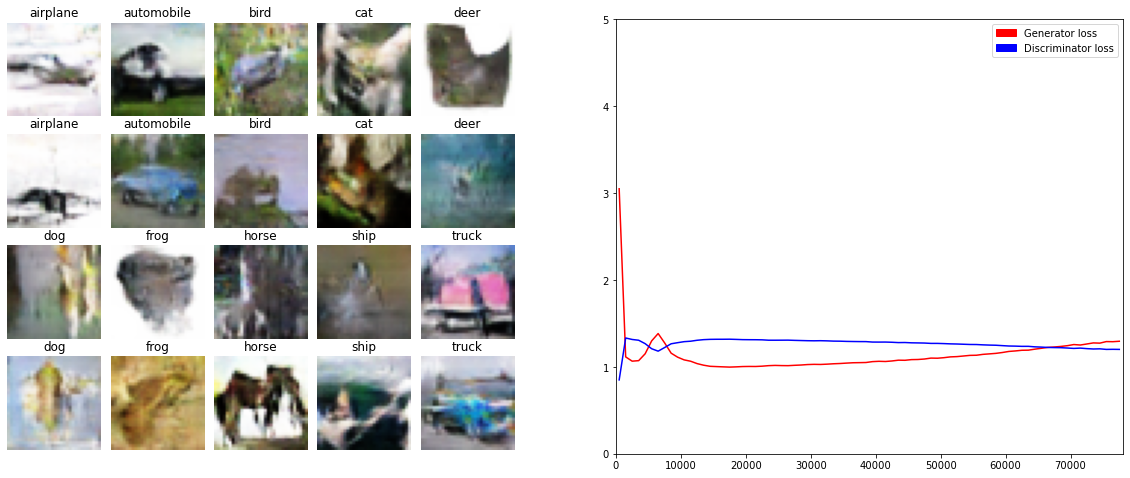

CPU times: user 18min 11s, sys: 8min 4s, total: 26min 16s
Wall time: 24min 21s


In [20]:
%%time
# Training
train(train_images, train_labels, EPOCHS, seed, seed_labels)

# Immedialty save the models
generator.save(    "." + os.sep + NAME_FILE + os.sep + 'new_models' + os.sep + 'generator.h5')
discriminator.save("." + os.sep + NAME_FILE + os.sep + 'new_models' + os.sep + 'discriminator.h5')

## Saving and loading the models

Saving the models and the losses

In [21]:
generator.save(    "." + os.sep + NAME_FILE + os.sep + 'new_models' + os.sep + 'generator_100.h5')
discriminator.save("." + os.sep + NAME_FILE + os.sep + 'new_models' + os.sep + 'discriminator_100.h5')

np.save("." + os.sep + NAME_FILE + os.sep + 'new_losses' + os.sep + 'g_losses_cond.npy',g_losses)
np.save("." + os.sep + NAME_FILE + os.sep + 'new_losses' + os.sep + 'd_losses_cond.npy',d_losses)

Loading the models

In [15]:
import os
generator_l =     tf.keras.models.load_model("." + os.sep + NAME_FILE + os.sep + "new_models" + os.sep + "generator.h5")
discriminator_l = tf.keras.models.load_model("." + os.sep + NAME_FILE + os.sep + "new_models" + os.sep + "discriminator.h5")

NameError: name 'NAME_FILE' is not defined

In [16]:
import os
generator_l = tf.keras.models.load_model("models/discriminator.h5")
discriminator_l = tf.keras.models.load_model("models/generator.h5")

## Visualizing the losses

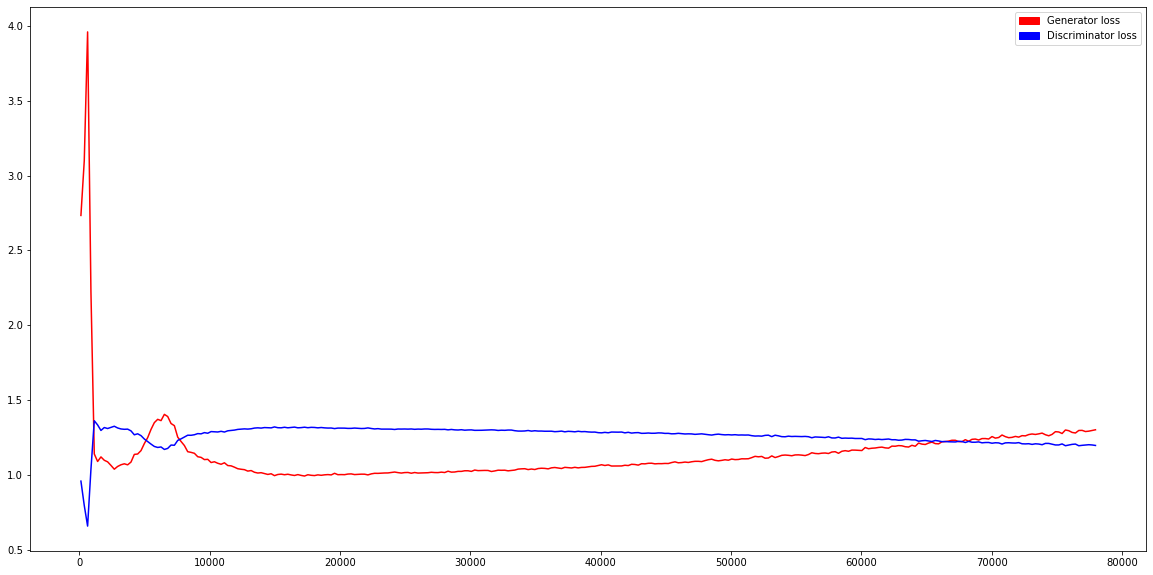

In [23]:
samples = 256
g_losses_sampled = []
d_losses_sampled = []
xs = []


for i in range(len(g_losses) // samples):
    g_losses_sampled.append(np.mean(g_losses[i*samples:(i+1)*samples]))
    d_losses_sampled.append(np.mean(d_losses[i*samples:(i+1)*samples]))
    xs.append(i*samples + samples/2)

plt.figure(figsize=(20,10))
  
plt.plot(xs, g_losses_sampled, "r-")
plt.plot(xs, d_losses_sampled, "b-")

red_patch = mpatches.Patch(color='red', label='Generator loss')
blue_patch = mpatches.Patch(color='blue', label='Discriminator loss')
plt.legend(handles=[red_patch,blue_patch])
plt.show()


## Generating a GIF of the training process

In [24]:
anim_file = "." + os.sep + NAME_FILE + os.sep + 'new_CIFAR-10.gif'
import imageio
with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob("." + os.sep + NAME_FILE + os.sep + 'imgs' + os.sep + 'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 10*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

## Generating samples from a specific class

In [17]:
def plot_img(pred, classes=None):
    fig = plt.figure(figsize=(10,10))

    for i in range(pred.shape[0]):
        plt.subplot(4, 5, i+1)
        if classes:
            plt.title(classes[k])
        plt.imshow((pred[i]+1) / 2)
        plt.axis('off')
    plt.show()

In [18]:
def show_class(model, k=None, classes=None):
    if classes:
        print("Generating {} images...".format(classes[k]))
        input = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
        labels = tf.one_hot([k]*NUM_EXAMPLES,10)
        predictions = model([input, labels], training=False)
    else:
        print("Generating images...")
        input = tf.random.normal([NUM_EXAMPLES, NOISE_DIM])
        labels=None
        predictions = model([input], training=False)
        
    print(predictions.shape)
    fig = plt.figure(figsize=(10,10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 5, i+1)
        if classes:
            plt.title(classes[k])
        plt.imshow((predictions[i]+1) / 2)
        plt.axis('off')
    plt.show()
    

In [19]:
for i in range(10):
    show_class(generator_l, k=i, classes=CLASSES)

NameError: name 'CLASSES' is not defined

## Inception Score 

In [23]:
# inception score

from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		# subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
# 		subset = preprocess_input(subset)
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std

In [21]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	X_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	X_input = X_input.reshape(n_samples, latent_dim)
	return X_input

# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :])
	plt.show()

NOISE_DIM =      100      # Amount of features for the generator    
NUM_EXAMPLES =   20       # Amount of examples to generate
    
# load model
model = load_model('models/generator.h5')
# model.summary()
# generate images
images = []
totalImageCount = 5000

for i in range(totalImageCount):
    input = tf.random.normal([1, NOISE_DIM])
    labels = tf.one_hot([1]*1,10)
    
    # generate images
    X = model([input, labels], training=False)
    X = tf.reshape(X, (32,32,3))
    images.append(X)

In [24]:
# shuffle images
shuffle(images)
images = np.array(images)
print('loaded', images.shape)
# calculate inception score
is_avg, is_std = calculate_inception_score(images)
print('score', is_avg, is_std)

loaded (5000, 32, 32, 3)
16/16 [==============================] - 14s 878ms/step
score 4.4992957 0.14606957


In [25]:
# Generate 1000 images and save the images
save_plot(images, 2, 32)

# CGAN

In [27]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
from tensorflow import keras
from keras.layers import Reshape, Conv2DTranspose, PReLU
from keras.utils import to_categorical, plot_model
from keras.layers import Concatenate
import numpy as np 
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
from scipy.linalg import sqrtm
import math
# from tqdm.notebook import tqdm
import tensorflow as tf
from IPython.display import clear_output, HTML
import glob
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from tensorflow_addons.layers import SpectralNormalization
from keras.layers import LeakyReLU, GlobalMaxPooling2D, GlobalAveragePooling2D

c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
I

In [3]:
from keras.datasets.cifar10 import load_data

(X_train, y_train), (X_test, y_test) = load_data()
X_train = np.concatenate((X_train, X_test), axis=0)
y_train = np.concatenate((y_train, y_test), axis=0)

In [23]:
type(X_train)

numpy.ndarray

In [4]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomCrop(32,32),
  # tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

X_train_aug = data_augmentation(X_train)
X_train = np.concatenate((X_train, X_train_aug), axis=0)

if X_train.shape[0] > 60000:
    y_train = np.concatenate((y_train, y_train), axis=0)

In [ ]:
class_labels = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
}

NUM_CLASS = 10

y_train = to_categorical(y_train)
pre_processing_v1 = Normalization()
pre_processing_v1.adapt(X_train)
X_train = X_train.astype('float32')
X_train /= (255/2)
X_train -= 1

In [38]:
noise = 128

# function to create generator model
def create_improve_cGAN_generator(noise):

    # gaussian weights initialization
    weights_init = RandomNormal(mean=0, stddev=0.02)

    # latent noise vector z
    z = Input(shape=(noise,), name="Latent_Noise_Vector_z")

    # conditions y
    conditions = Input(shape=(10,), name='Conditions_y')

    # Generator network
    merged_layer = Concatenate()([z, conditions])

    # FC: 2x2x512
    generator = Dense(2*2*512, activation='relu')(merged_layer)
    generator = BatchNormalization(momentum=0.8)(generator)
    generator = PReLU()(generator)
    generator = Reshape((2, 2, 512))(generator)

    base_generator = Sequential([
        # Conv 1: 4x4x256
        SpectralNormalization(Conv2DTranspose(256, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
        # Conv 2: 8x8x128
        SpectralNormalization(Conv2DTranspose(128, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
        # Conv 3: 16x16x64
        SpectralNormalization(Conv2DTranspose(64, kernel_size=4, strides=2,
                                              padding='same', kernel_initializer=weights_init)),
        BatchNormalization(momentum=0.8),
        PReLU(),
    ], name='Base_Generator')
    generator = base_generator(generator)

    # Conv 4: 32x32x3
    generator = Conv2DTranspose(3, kernel_size=4, strides=2, padding='same',
                                activation='tanh', name='Output_Layer')(generator)

    generator = Model(inputs=[z, conditions],
                      outputs=generator,  name='generator_cGAN')
    return generator

In [39]:
# function to create discriminator model
def create_improve_cGAN_discriminator(image_size):
    # input image
    img_input = Input(shape=(image_size), name='Image_Input')
    weights_init = RandomNormal(mean=0, stddev=0.02)

    # conditions y
    conditions = Input(shape=(10,), name='Conditions_y')

    base_discriminator = Sequential([
        Conv2D(64, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(128, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(256, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
        Conv2D(512, kernel_size=4, strides=2, padding='same',
               kernel_initializer=weights_init),
        BatchNormalization(momentum=0.8),
        LeakyReLU(0.2),
    ], name='Base_Discriminator')
    discriminator = base_discriminator(img_input)

    discriminator = GlobalAveragePooling2D()(discriminator)

    # Concatenate - combine with conditions y
    merged_layer = Concatenate()([discriminator, conditions])
    discriminator = Dense(512, activation='relu')(merged_layer)

    # Output
    discriminator = Dense(1,
                          name='Output_Layer')(discriminator)

    discriminator = Model(inputs=[img_input, conditions],
                          outputs=discriminator, name='discriminator_cGAN')
    return discriminator

In [40]:
class NewcGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=20, noise=128, patience=10, vmin=0, vmax=1):
        self.num_img = num_img
        self.noise = noise
        self.patience = patience
        self.vmin = vmin
        self.vmax = vmax
        self.latent_noise_vector = tf.random.normal(
            shape=(self.num_img, self.noise))
        self.conditions = to_categorical([0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                          0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

    def generate_plot(self):
        # Generate Images
        generated_images = self.model.generator.predict(
            [self.latent_noise_vector, self.conditions])
        # Normalise Image from [vmin, vmax] to [0, 1]
        generated_images -= self.vmin
        generated_images /= (self.vmax - self.vmin)
        row_size = int(np.ceil(self.num_img/5))
        fig = plt.figure(figsize=(10, 2*row_size), tight_layout=True)
        for i in range(self.num_img):
            ax = fig.add_subplot(row_size, 5, i+1)
            ax.imshow(generated_images[i])
            ax.set_title(class_labels[i % 10])
            ax.axis('off')
        plt.show()

    def save_weights(self, epoch=None):
        try:
            if epoch != None:
                name = 'cGAN/generator-epoch-{}.h5'.format(epoch)
                print('Generator Checkpoint - {}'.format(name))
                self.model.generator.save_weights(
                    filepath=name,
                    save_format='h5'
                )
        except Exception as e:
            print(e)

    def on_epoch_begin(self, epoch, logs=None):
        if epoch % self.patience == 0:
            self.generate_plot()
            self.save_weights(epoch)

    def on_train_end(self, epoch, logs=None):
        self.generate_plot()
        self.save_weights('Full Train')


In [41]:
callbacks = [
    NewcGANMonitor(num_img=20, noise=128, patience=5, vmin=-1, vmax=1),
]


In [42]:
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, noise):
        super(ConditionalGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise = noise
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(
            name="discriminator_loss")
        # self.d_xy_tracker = tf.keras.metrics.Mean(name='Mean D(x|y)')
        # self.d_g_zy_tracker = tf.keras.metrics.Mean(name='Mean D(G(z|y))')
        self.kl = tf.keras.metrics.KLDivergence()

    def compile(self, d_optimizer, g_optimizer, gloss_fn, dloss_fn):
        super(ConditionalGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.gloss_fn = gloss_fn
        self.dloss_fn = dloss_fn

    def train_step(self, data):
        ### TRAINING DISCRIMINATOR ###
        # Unpack the data.
        real_images, condition = data

        # Sample for latent noise vector z
        batch_size = tf.shape(real_images)[0]
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.noise))

        # Maps the noise latent vector and labels to generate fake images.
        generated_images = self.generator([latent_noise_vector, condition])

        # Combine with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        combined_condition = tf.concat([condition, condition], axis=0)

        # Discrimination
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            first_predictions = self.discriminator(
                [combined_images, combined_condition])
            d_loss = self.dloss_fn(labels, first_predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # # Computing D(x|y)
        # d_xy = tf.math.reduce_mean(first_predictions)

        ### TRAINING GENRATOR ###
        latent_noise_vector = tf.random.normal(shape=(batch_size, self.noise))

        # Assemble labels that say "all real images".
        misleading_labels = tf.ones((batch_size, 1))

        with tf.GradientTape() as tape:
            fake_images = self.generator([latent_noise_vector, condition])
            second_predictions = self.discriminator([fake_images, condition])
            g_loss = self.gloss_fn(misleading_labels, second_predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        # # Computing D(G(z|y))
        # d_g_zy = tf.math.reduce_mean(second_predictions)

        # Monitor loss and metrics.

        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.kl.update_state(y_true=real_images, y_pred=generated_images)

        return {
            "d_loss": self.disc_loss_tracker.result(),
            "g_loss": self.gen_loss_tracker.result(),
            "KL Divergence": self.kl.result(),
        }

In [43]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # we compare the prediction on real images to 0.8 instead of 1
    real_loss = loss_function(tf.ones_like(real_output)*0.8, real_output)
    # real_loss will quantify our loss to distinguish the real images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    # fake_loss will quantify our loss to distinguish the fake images (generated)
    
    # Two-sided label smoothing : 
    # Uncomment the next line and comment the last one if you want to try it
#     fake_loss = loss_function(tf.ones_like(fake_output)*0.1, fake_output)
    
    # Real image = 1, Fake image = 0 (array of ones and zeros)
    total_loss = real_loss + fake_loss
    return total_loss

# def generator_loss(fake_output):
#     # We want the false images to be seen as real images (1)
#     return loss_function(tf.ones_like(fake_output), fake_output)

In [44]:
improve_cond_gan = ConditionalGAN(
    discriminator=create_improve_cGAN_discriminator(image_size=(32, 32, 3)),
    generator=create_improve_cGAN_generator(noise=128),
    noise=128
)

improve_cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    gloss_fn=loss_function,
    dloss_fn=loss_function
)

c:\Users\hazem\anaconda3\envs\gpu_env\lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


1/1 [==============================] - 0s 132ms/step


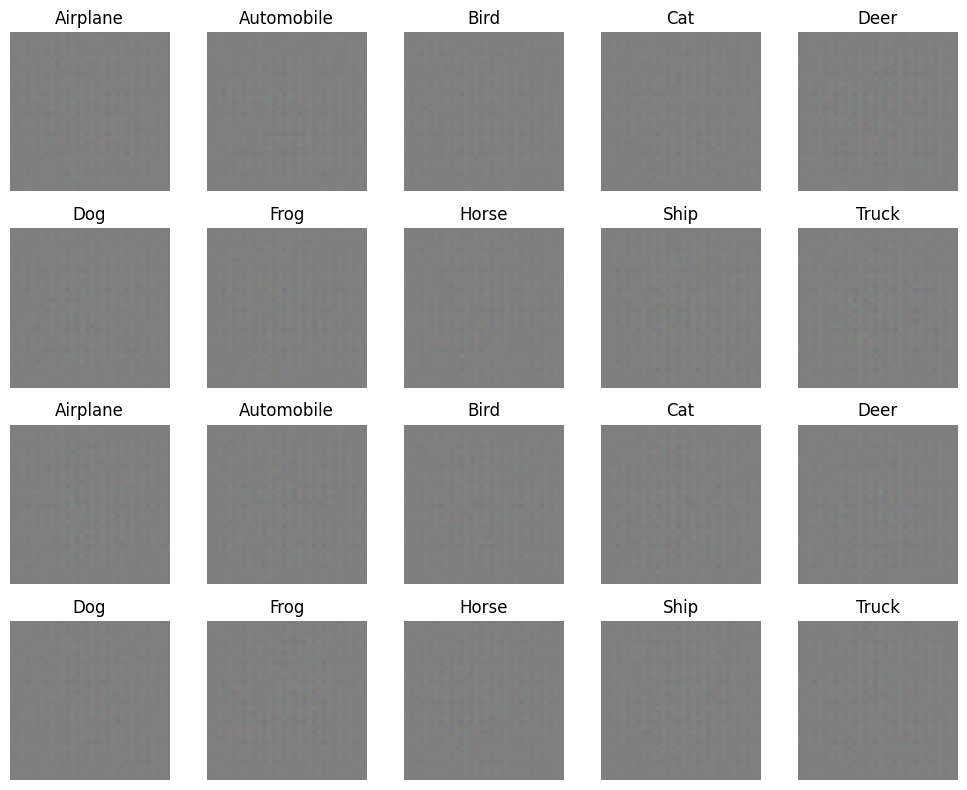

Generator Checkpoint - cGAN/generator-epoch-0.h5
Epoch 1/100
1875/1875 [==============================] - 280s 148ms/step - d_loss: 0.2821 - g_loss: 3.3315 - KL Divergence: 6.1021
Epoch 2/100
1875/1875 [==============================] - 274s 146ms/step - d_loss: 0.2341 - g_loss: 3.3574 - KL Divergence: 6.3399
Epoch 3/100
1875/1875 [==============================] - 271s 145ms/step - d_loss: 0.2886 - g_loss: 2.8407 - KL Divergence: 5.3156
Epoch 4/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.3149 - g_loss: 2.6410 - KL Divergence: 4.9723
Epoch 5/100
1/1 [==============================] - 0s 22ms/step


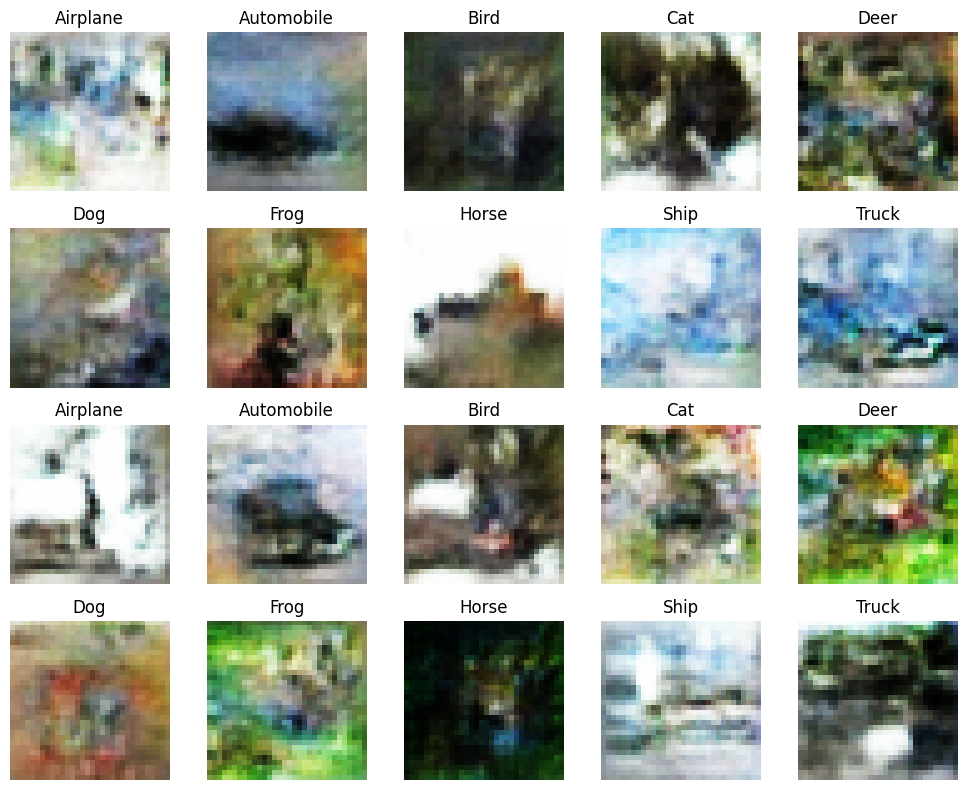

Generator Checkpoint - cGAN/generator-epoch-5.h5
Epoch 6/100
1875/1875 [==============================] - 268s 143ms/step - d_loss: 0.3103 - g_loss: 2.5932 - KL Divergence: 4.4738
Epoch 7/100
1875/1875 [==============================] - 271s 145ms/step - d_loss: 0.3178 - g_loss: 2.4598 - KL Divergence: 4.6226
Epoch 8/100
1875/1875 [==============================] - 273s 145ms/step - d_loss: 0.3310 - g_loss: 2.3686 - KL Divergence: 4.6441
Epoch 9/100
1875/1875 [==============================] - 274s 146ms/step - d_loss: 0.3120 - g_loss: 2.4270 - KL Divergence: 4.5976
Epoch 10/100
1/1 [==============================] - 0s 22ms/step


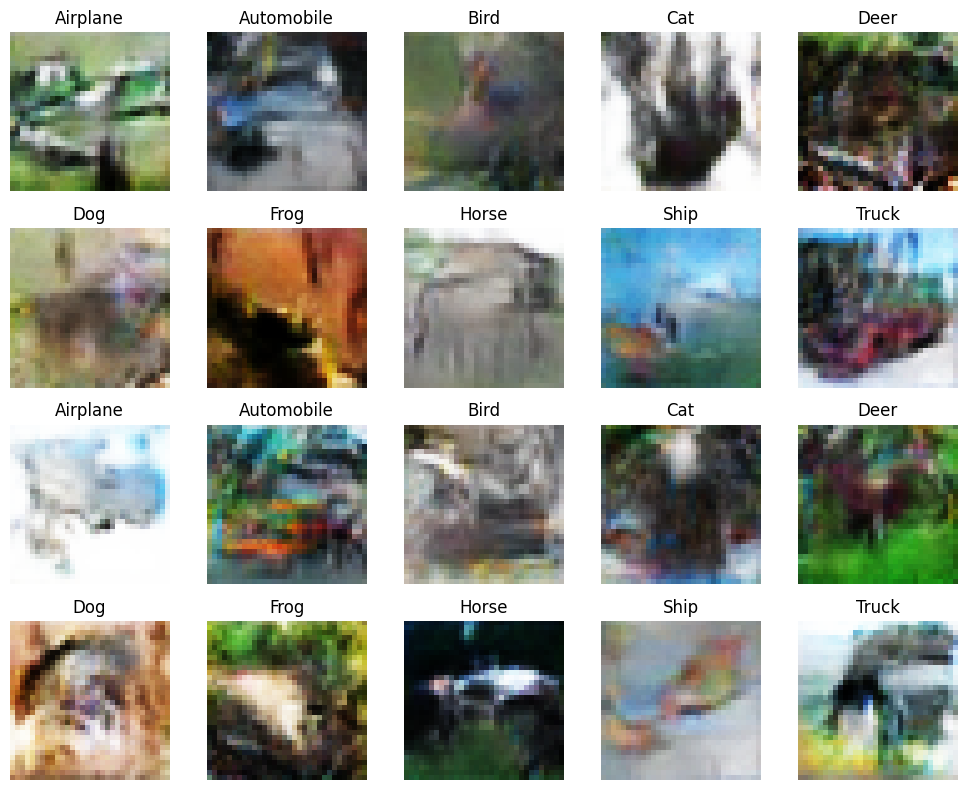

Generator Checkpoint - cGAN/generator-epoch-10.h5
Epoch 11/100
1875/1875 [==============================] - 273s 146ms/step - d_loss: 0.3002 - g_loss: 2.5499 - KL Divergence: 4.6646
Epoch 12/100
1875/1875 [==============================] - 273s 146ms/step - d_loss: 0.2970 - g_loss: 2.5856 - KL Divergence: 4.6502
Epoch 13/100
1875/1875 [==============================] - 273s 145ms/step - d_loss: 0.2904 - g_loss: 2.6576 - KL Divergence: 4.7017
Epoch 14/100
1875/1875 [==============================] - 274s 146ms/step - d_loss: 0.2817 - g_loss: 2.7529 - KL Divergence: 4.7220
Epoch 15/100
1/1 [==============================] - 0s 23ms/step


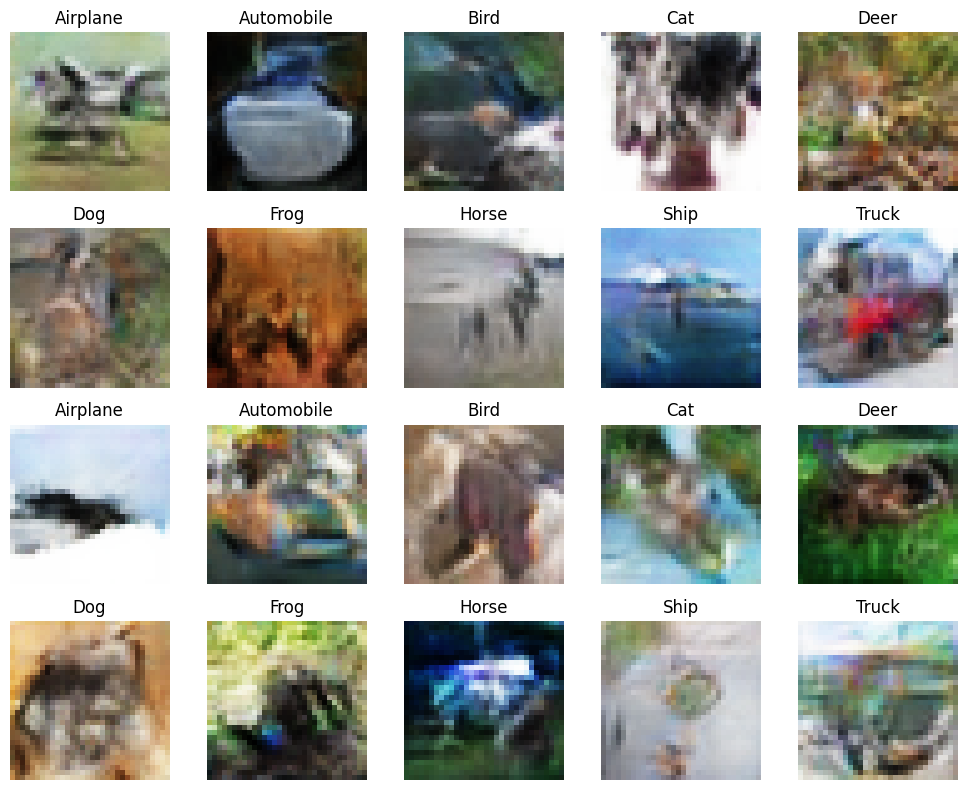

Generator Checkpoint - cGAN/generator-epoch-15.h5
Epoch 16/100
1875/1875 [==============================] - 269s 144ms/step - d_loss: 0.2629 - g_loss: 2.9333 - KL Divergence: 4.7471
Epoch 17/100
1875/1875 [==============================] - 268s 143ms/step - d_loss: 0.2524 - g_loss: 3.0648 - KL Divergence: 4.7576
Epoch 18/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.2477 - g_loss: 3.1141 - KL Divergence: 4.7982
Epoch 19/100
1875/1875 [==============================] - 268s 143ms/step - d_loss: 0.2352 - g_loss: 3.2647 - KL Divergence: 4.7211
Epoch 20/100
1/1 [==============================] - 0s 23ms/step


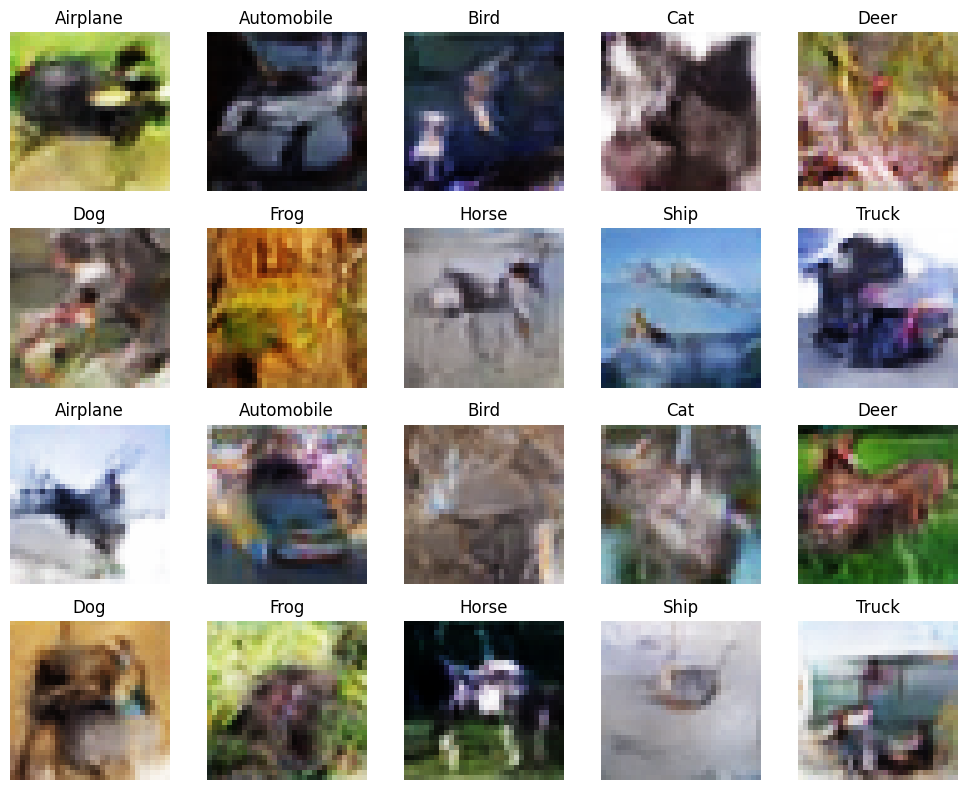

Generator Checkpoint - cGAN/generator-epoch-20.h5
Epoch 21/100
1875/1875 [==============================] - 272s 145ms/step - d_loss: 0.2168 - g_loss: 3.5471 - KL Divergence: 4.7275
Epoch 22/100
1875/1875 [==============================] - 271s 144ms/step - d_loss: 0.2114 - g_loss: 3.6157 - KL Divergence: 4.7601
Epoch 23/100
1875/1875 [==============================] - 272s 145ms/step - d_loss: 0.2032 - g_loss: 3.7859 - KL Divergence: 4.6894
Epoch 24/100
1875/1875 [==============================] - 276s 147ms/step - d_loss: 0.2010 - g_loss: 3.8487 - KL Divergence: 4.7371
Epoch 25/100
1/1 [==============================] - 0s 22ms/step


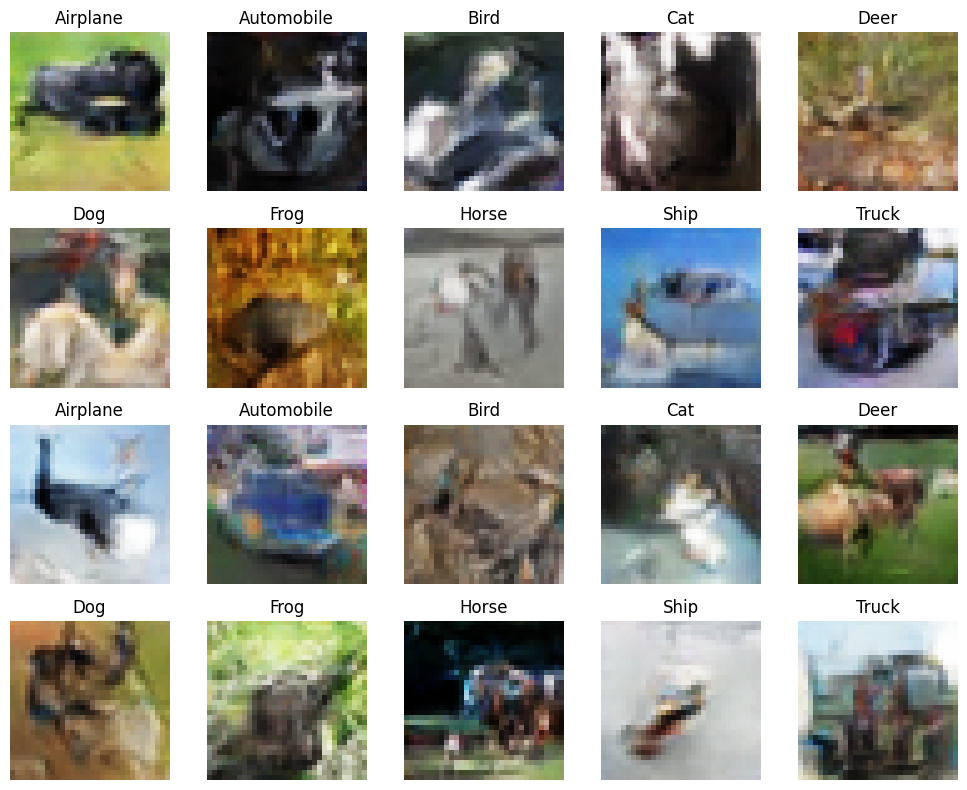

Generator Checkpoint - cGAN/generator-epoch-25.h5
Epoch 26/100
1875/1875 [==============================] - 273s 146ms/step - d_loss: 0.1909 - g_loss: 4.0673 - KL Divergence: 4.7770
Epoch 27/100
1875/1875 [==============================] - 277s 148ms/step - d_loss: 0.1853 - g_loss: 4.1509 - KL Divergence: 4.7263
Epoch 28/100
1875/1875 [==============================] - 270s 144ms/step - d_loss: 0.1809 - g_loss: 4.2744 - KL Divergence: 4.7595
Epoch 29/100
1875/1875 [==============================] - 278s 148ms/step - d_loss: 0.1815 - g_loss: 4.2760 - KL Divergence: 4.6969
Epoch 30/100
1/1 [==============================] - 0s 21ms/step


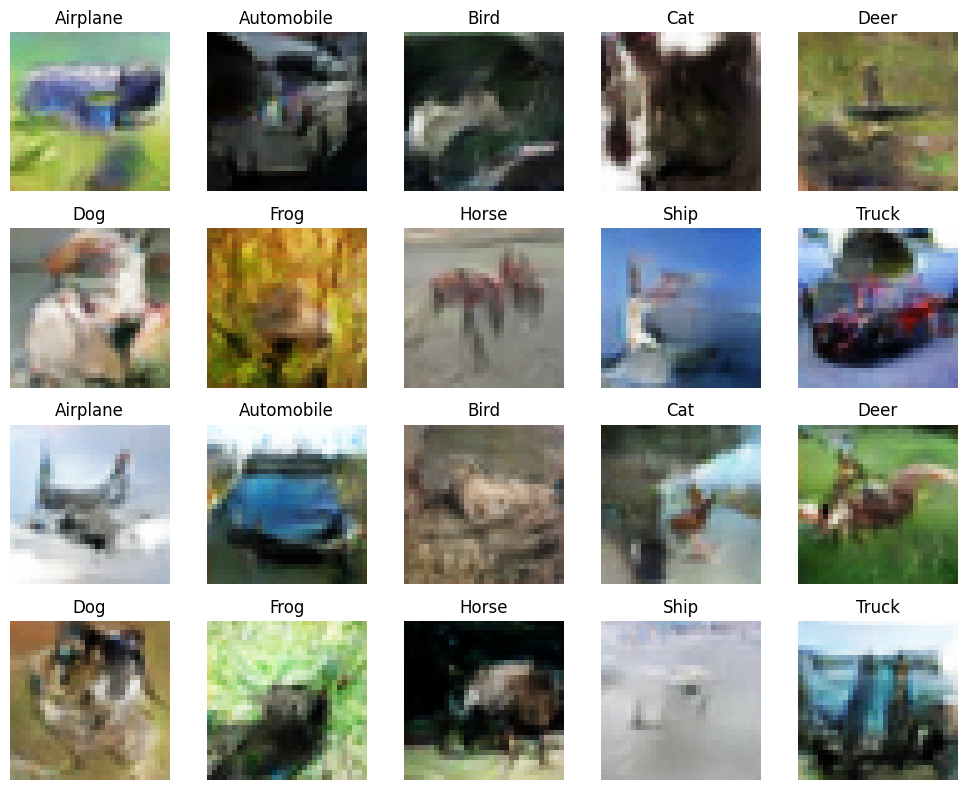

Generator Checkpoint - cGAN/generator-epoch-30.h5
Epoch 31/100
1875/1875 [==============================] - 266s 142ms/step - d_loss: 0.1682 - g_loss: 4.5403 - KL Divergence: 4.6540
Epoch 32/100
1875/1875 [==============================] - 266s 142ms/step - d_loss: 0.1635 - g_loss: 4.5632 - KL Divergence: 4.6480
Epoch 33/100
1875/1875 [==============================] - 269s 143ms/step - d_loss: 0.1632 - g_loss: 4.6876 - KL Divergence: 4.6833
Epoch 34/100
1875/1875 [==============================] - 266s 142ms/step - d_loss: 0.1641 - g_loss: 4.7648 - KL Divergence: 4.7034
Epoch 35/100
1/1 [==============================] - 0s 21ms/step


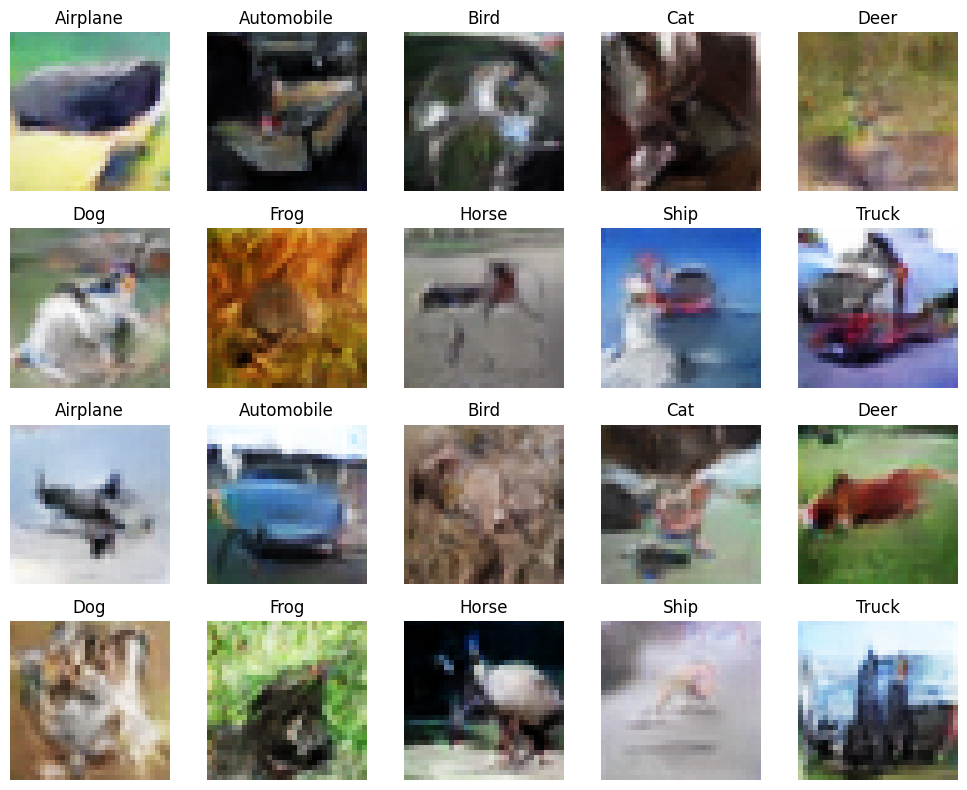

Generator Checkpoint - cGAN/generator-epoch-35.h5
Epoch 36/100
1875/1875 [==============================] - 267s 143ms/step - d_loss: 0.1540 - g_loss: 4.9101 - KL Divergence: 4.6719
Epoch 37/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1514 - g_loss: 5.0016 - KL Divergence: 4.6782
Epoch 38/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1510 - g_loss: 5.0431 - KL Divergence: 4.7418
Epoch 39/100
1875/1875 [==============================] - 268s 143ms/step - d_loss: 0.1509 - g_loss: 5.0656 - KL Divergence: 4.6220
Epoch 40/100
1/1 [==============================] - 0s 20ms/step


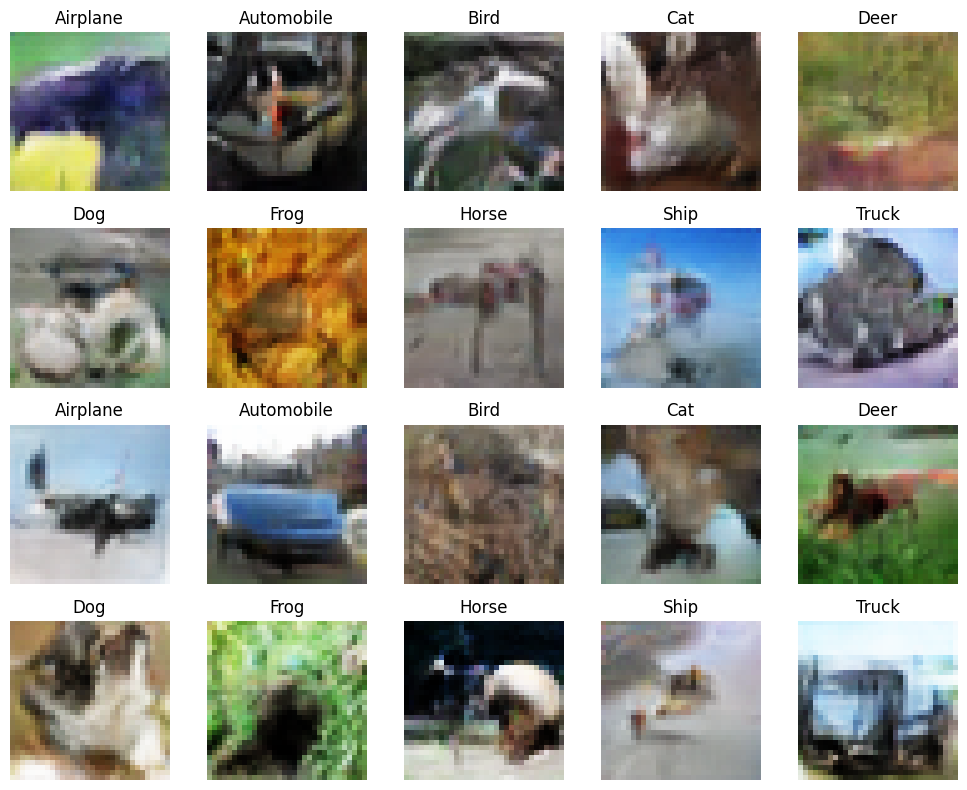

Generator Checkpoint - cGAN/generator-epoch-40.h5
Epoch 41/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1484 - g_loss: 5.2278 - KL Divergence: 4.6387
Epoch 42/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1482 - g_loss: 5.2416 - KL Divergence: 4.7155
Epoch 43/100
1875/1875 [==============================] - 270s 144ms/step - d_loss: 0.1440 - g_loss: 5.3097 - KL Divergence: 4.5251
Epoch 44/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1453 - g_loss: 5.3269 - KL Divergence: 4.6976
Epoch 45/100
1/1 [==============================] - 0s 22ms/step


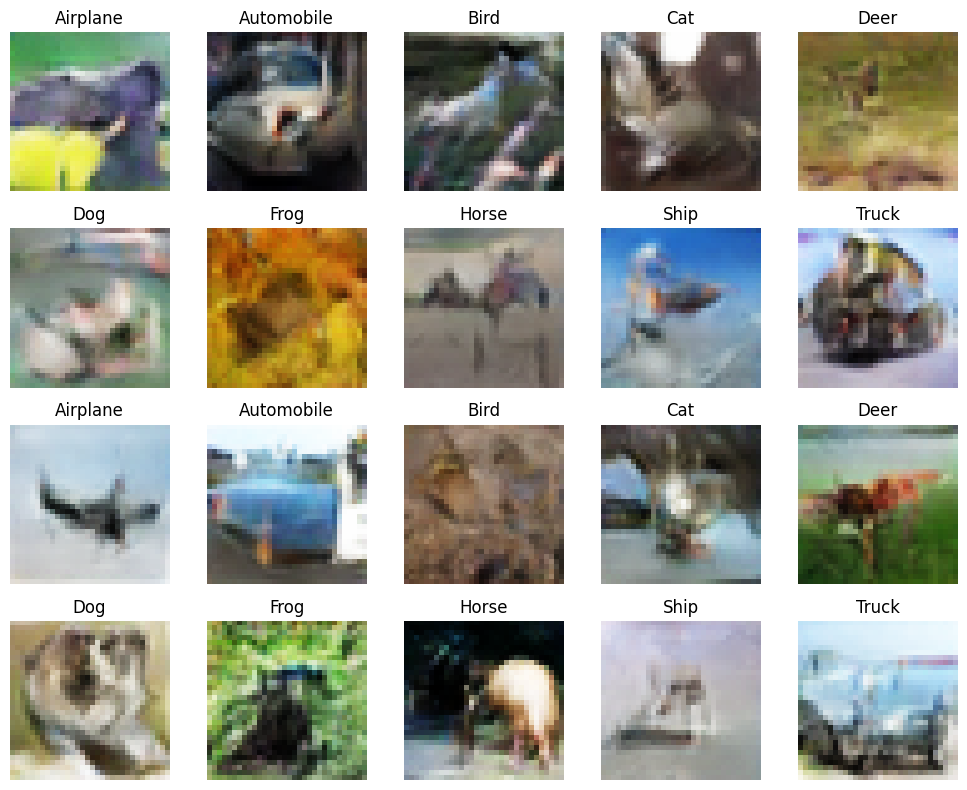

Generator Checkpoint - cGAN/generator-epoch-45.h5
Epoch 46/100
1875/1875 [==============================] - 271s 144ms/step - d_loss: 0.1372 - g_loss: 5.4514 - KL Divergence: 4.6131
Epoch 47/100
1875/1875 [==============================] - 266s 142ms/step - d_loss: 0.1423 - g_loss: 5.4507 - KL Divergence: 4.6659
Epoch 48/100
1875/1875 [==============================] - 270s 144ms/step - d_loss: 0.1392 - g_loss: 5.5232 - KL Divergence: 4.7877
Epoch 49/100
1875/1875 [==============================] - 279s 149ms/step - d_loss: 0.1395 - g_loss: 5.5722 - KL Divergence: 4.6756
Epoch 50/100
1/1 [==============================] - 0s 29ms/step


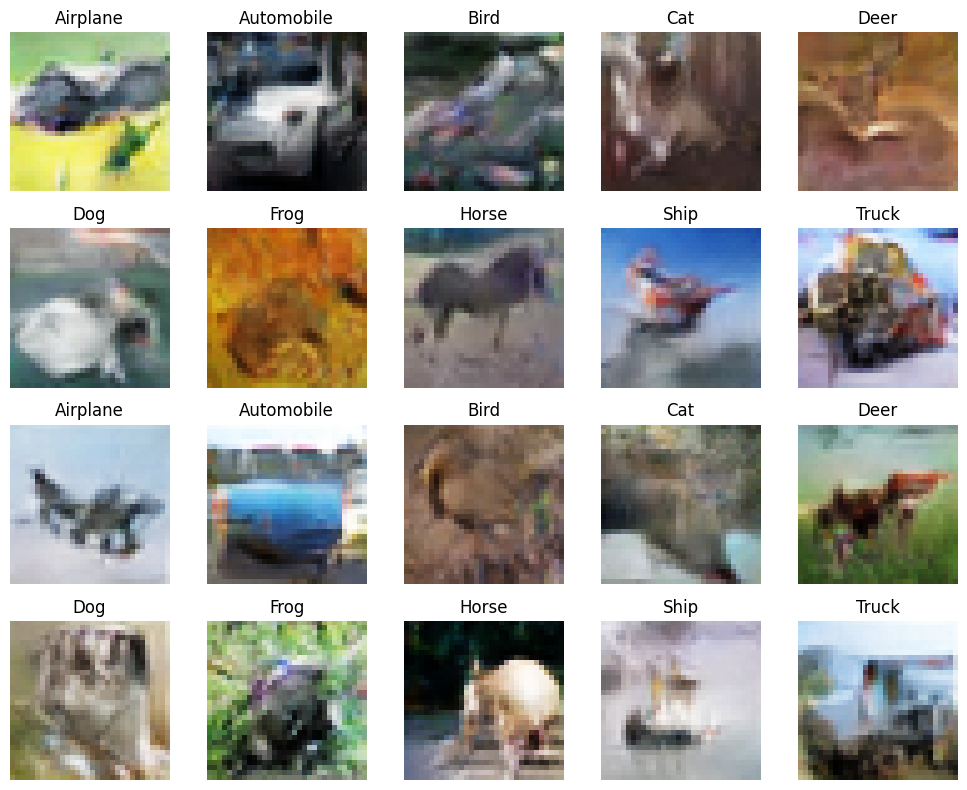

Generator Checkpoint - cGAN/generator-epoch-50.h5
Epoch 51/100
1875/1875 [==============================] - 271s 144ms/step - d_loss: 0.1396 - g_loss: 5.5881 - KL Divergence: 4.6650
Epoch 52/100
1875/1875 [==============================] - 267s 142ms/step - d_loss: 0.1327 - g_loss: 5.6722 - KL Divergence: 4.6453
Epoch 53/100
1875/1875 [==============================] - 265s 141ms/step - d_loss: 0.1358 - g_loss: 5.6872 - KL Divergence: 4.7000
Epoch 54/100
1875/1875 [==============================] - 264s 141ms/step - d_loss: 0.1322 - g_loss: 5.7833 - KL Divergence: 4.6595
Epoch 55/100
1/1 [==============================] - 0s 21ms/step


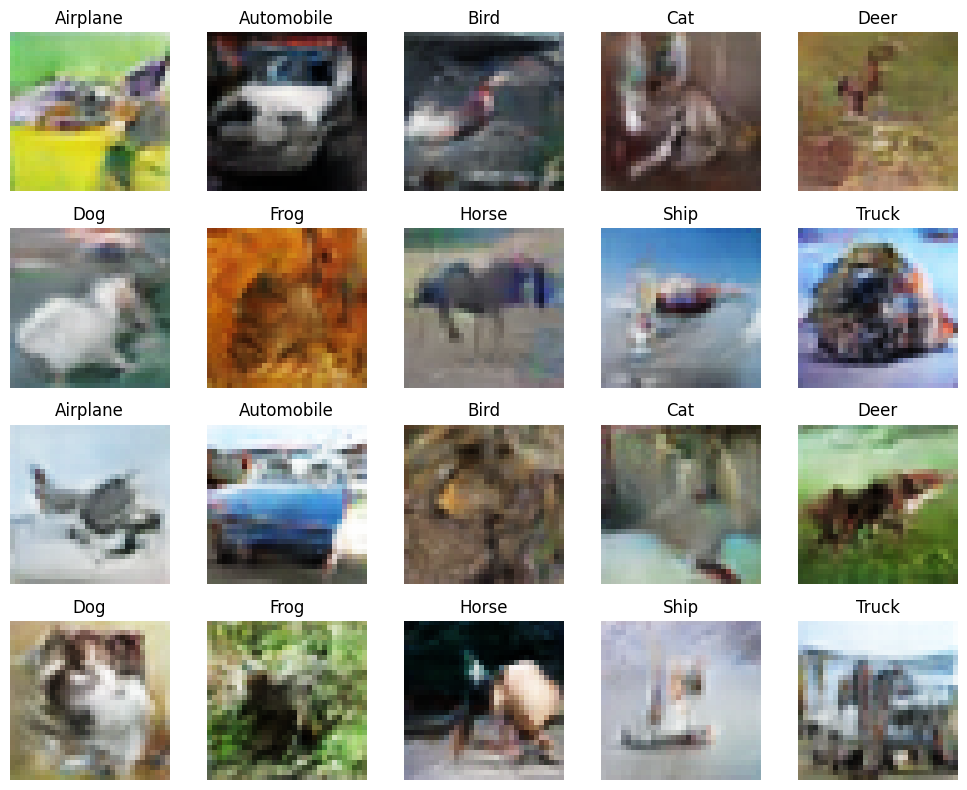

Generator Checkpoint - cGAN/generator-epoch-55.h5
Epoch 56/100
1875/1875 [==============================] - 264s 141ms/step - d_loss: 0.1293 - g_loss: 5.8479 - KL Divergence: 4.7187
Epoch 57/100
1875/1875 [==============================] - 266s 142ms/step - d_loss: 0.1285 - g_loss: 5.8747 - KL Divergence: 4.6459
Epoch 58/100
1875/1875 [==============================] - 263s 140ms/step - d_loss: 0.1260 - g_loss: 5.9498 - KL Divergence: 4.5555
Epoch 59/100
1875/1875 [==============================] - 263s 140ms/step - d_loss: 0.1230 - g_loss: 6.0009 - KL Divergence: 4.4701
Epoch 60/100
1/1 [==============================] - 0s 22ms/step


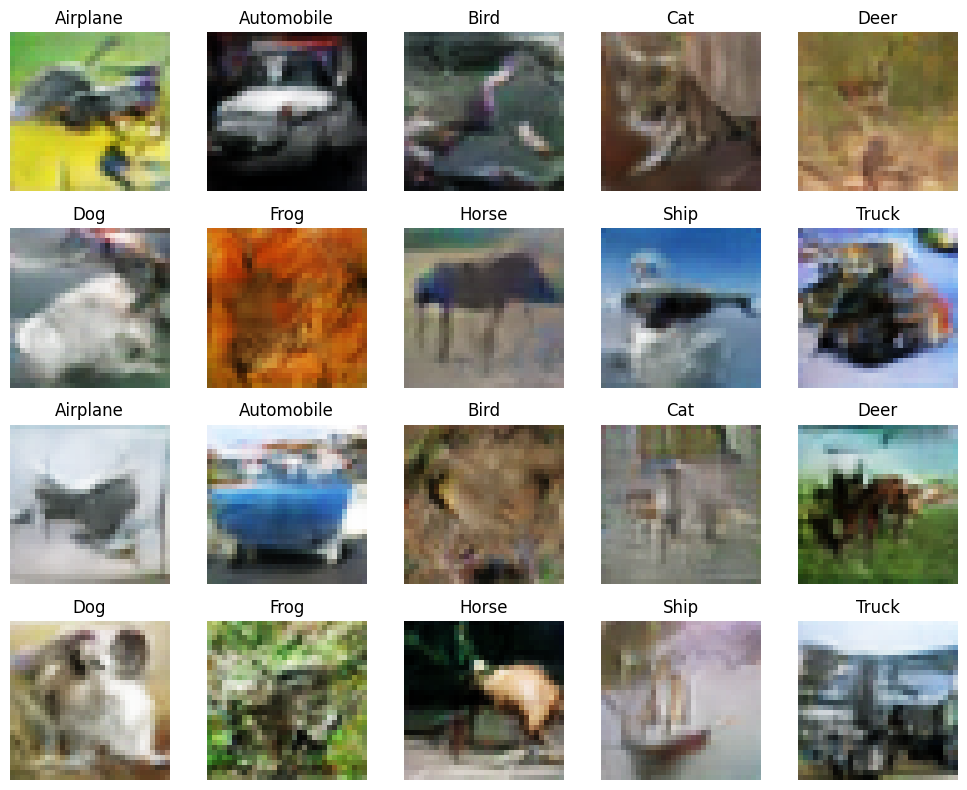

Generator Checkpoint - cGAN/generator-epoch-60.h5
Epoch 61/100
1875/1875 [==============================] - 263s 140ms/step - d_loss: 0.1225 - g_loss: 6.0558 - KL Divergence: 4.6665
Epoch 62/100
1875/1875 [==============================] - 263s 140ms/step - d_loss: 0.1207 - g_loss: 6.1093 - KL Divergence: 4.8056
Epoch 63/100
1875/1875 [==============================] - 297s 158ms/step - d_loss: 0.1189 - g_loss: 6.1579 - KL Divergence: 4.6029
Epoch 64/100
1875/1875 [==============================] - 304s 162ms/step - d_loss: 0.1214 - g_loss: 6.1085 - KL Divergence: 4.5985
Epoch 65/100
1/1 [==============================] - 0s 23ms/step


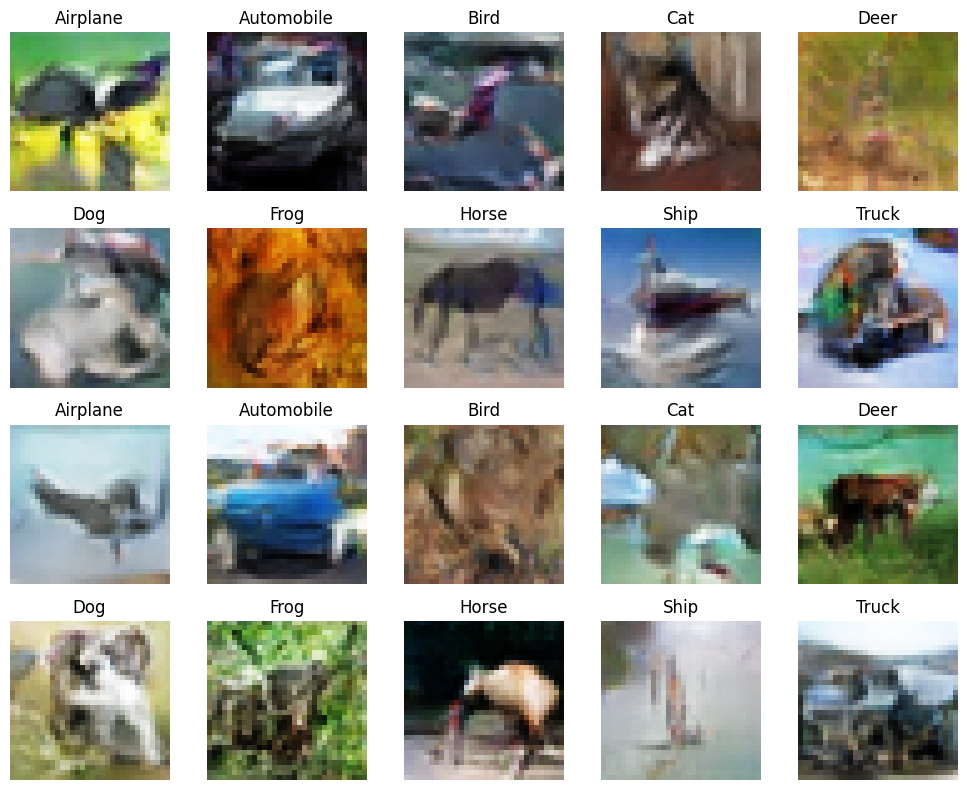

Generator Checkpoint - cGAN/generator-epoch-65.h5
Epoch 66/100
1875/1875 [==============================] - 313s 167ms/step - d_loss: 0.1203 - g_loss: 6.2537 - KL Divergence: 4.5490
Epoch 67/100
1875/1875 [==============================] - 297s 158ms/step - d_loss: 0.1178 - g_loss: 6.2439 - KL Divergence: 4.5633
Epoch 68/100
1875/1875 [==============================] - 278s 148ms/step - d_loss: 0.1156 - g_loss: 6.3793 - KL Divergence: 4.6108
Epoch 69/100
1875/1875 [==============================] - 279s 149ms/step - d_loss: 0.1127 - g_loss: 6.4118 - KL Divergence: 4.4420
Epoch 70/100
1/1 [==============================] - 0s 24ms/step


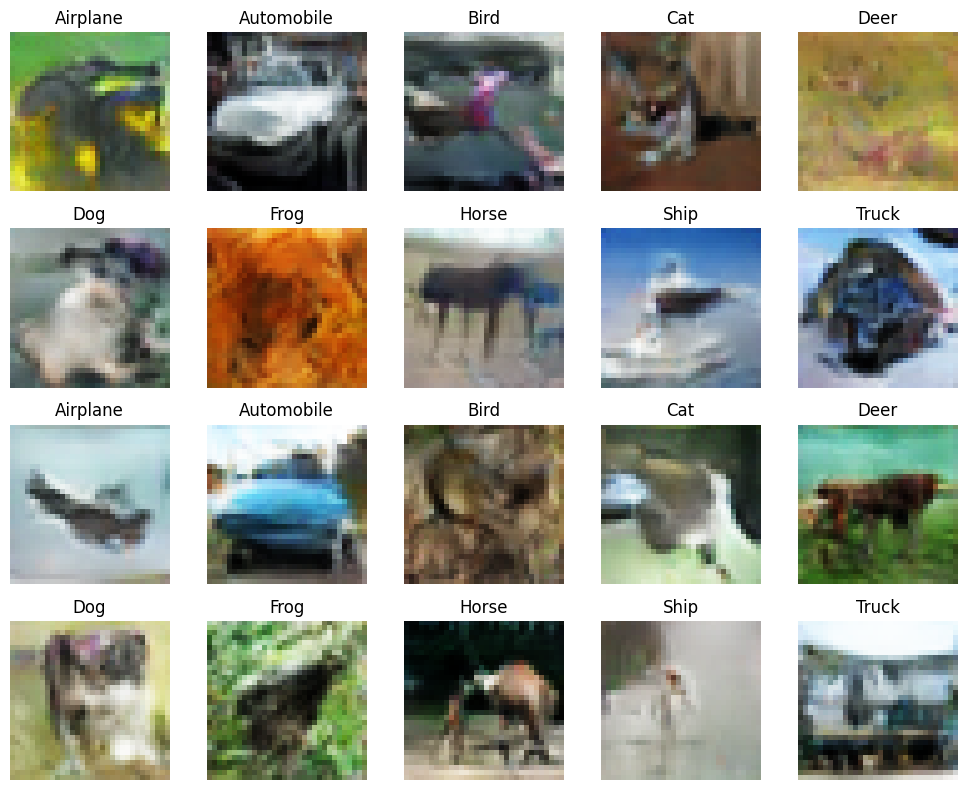

Generator Checkpoint - cGAN/generator-epoch-70.h5
Epoch 71/100
1875/1875 [==============================] - 284s 151ms/step - d_loss: 0.1130 - g_loss: 6.4622 - KL Divergence: 4.6571
Epoch 72/100
1875/1875 [==============================] - 289s 154ms/step - d_loss: 0.1094 - g_loss: 6.5799 - KL Divergence: 4.3823
Epoch 73/100
1875/1875 [==============================] - 291s 155ms/step - d_loss: 0.1111 - g_loss: 6.5457 - KL Divergence: 4.6741
Epoch 74/100
1875/1875 [==============================] - 290s 154ms/step - d_loss: 0.1066 - g_loss: 6.6227 - KL Divergence: 4.6237
Epoch 75/100
1/1 [==============================] - 0s 25ms/step


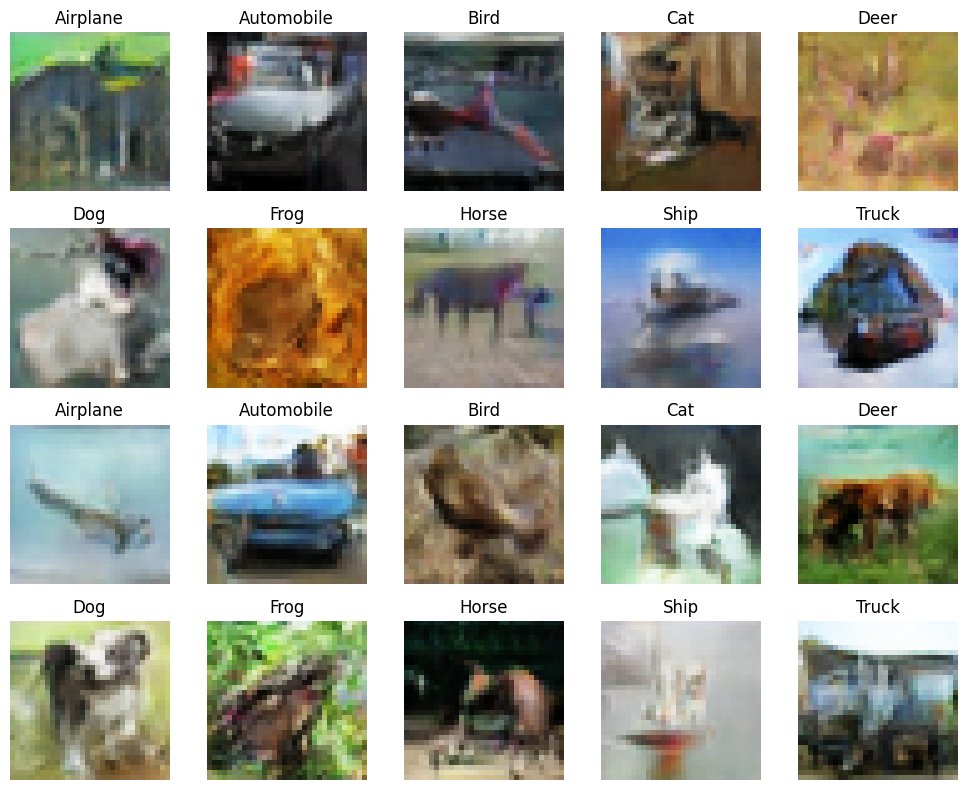

Generator Checkpoint - cGAN/generator-epoch-75.h5
Epoch 76/100
1875/1875 [==============================] - 286s 153ms/step - d_loss: 0.1075 - g_loss: 6.7137 - KL Divergence: 4.7521
Epoch 77/100
1875/1875 [==============================] - 276s 147ms/step - d_loss: 0.1065 - g_loss: 6.6124 - KL Divergence: 4.6804
Epoch 78/100
1875/1875 [==============================] - 286s 152ms/step - d_loss: 0.1110 - g_loss: 6.7395 - KL Divergence: 4.5162
Epoch 79/100
1875/1875 [==============================] - 286s 152ms/step - d_loss: 0.1071 - g_loss: 6.7056 - KL Divergence: 4.6781
Epoch 80/100
1/1 [==============================] - 0s 24ms/step


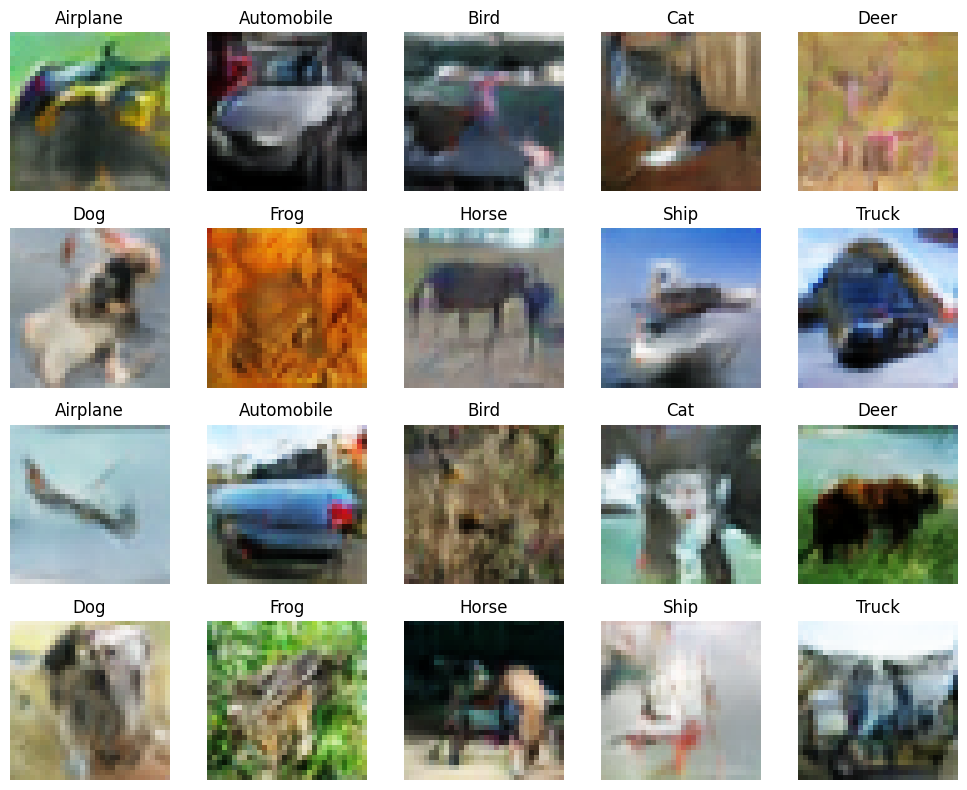

Generator Checkpoint - cGAN/generator-epoch-80.h5
Epoch 81/100
1875/1875 [==============================] - 280s 149ms/step - d_loss: 0.1036 - g_loss: 6.8385 - KL Divergence: 4.4479
Epoch 82/100
1875/1875 [==============================] - 301s 160ms/step - d_loss: 0.1041 - g_loss: 6.8705 - KL Divergence: 4.6812
Epoch 83/100
1875/1875 [==============================] - 280s 149ms/step - d_loss: 0.1030 - g_loss: 6.8977 - KL Divergence: 4.6251
Epoch 84/100
1875/1875 [==============================] - 273s 146ms/step - d_loss: 0.1039 - g_loss: 6.8800 - KL Divergence: 4.4934
Epoch 85/100
1/1 [==============================] - 0s 30ms/step


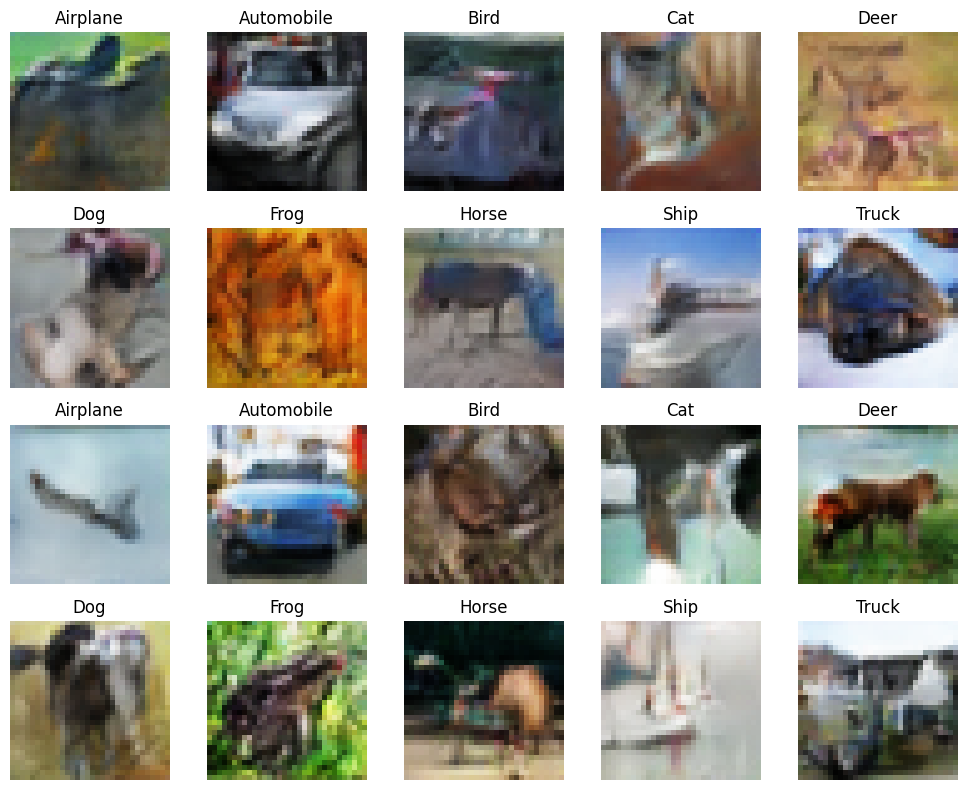

Generator Checkpoint - cGAN/generator-epoch-85.h5
Epoch 86/100
1875/1875 [==============================] - 291s 155ms/step - d_loss: 0.0959 - g_loss: 7.0273 - KL Divergence: 4.6262
Epoch 87/100
1875/1875 [==============================] - 290s 155ms/step - d_loss: 0.1001 - g_loss: 6.9324 - KL Divergence: 4.4268
Epoch 88/100
1875/1875 [==============================] - 273s 146ms/step - d_loss: 0.0980 - g_loss: 6.9376 - KL Divergence: 4.5927
Epoch 89/100
1875/1875 [==============================] - 275s 147ms/step - d_loss: 0.0976 - g_loss: 7.0986 - KL Divergence: 4.4295
Epoch 90/100
1/1 [==============================] - 0s 22ms/step


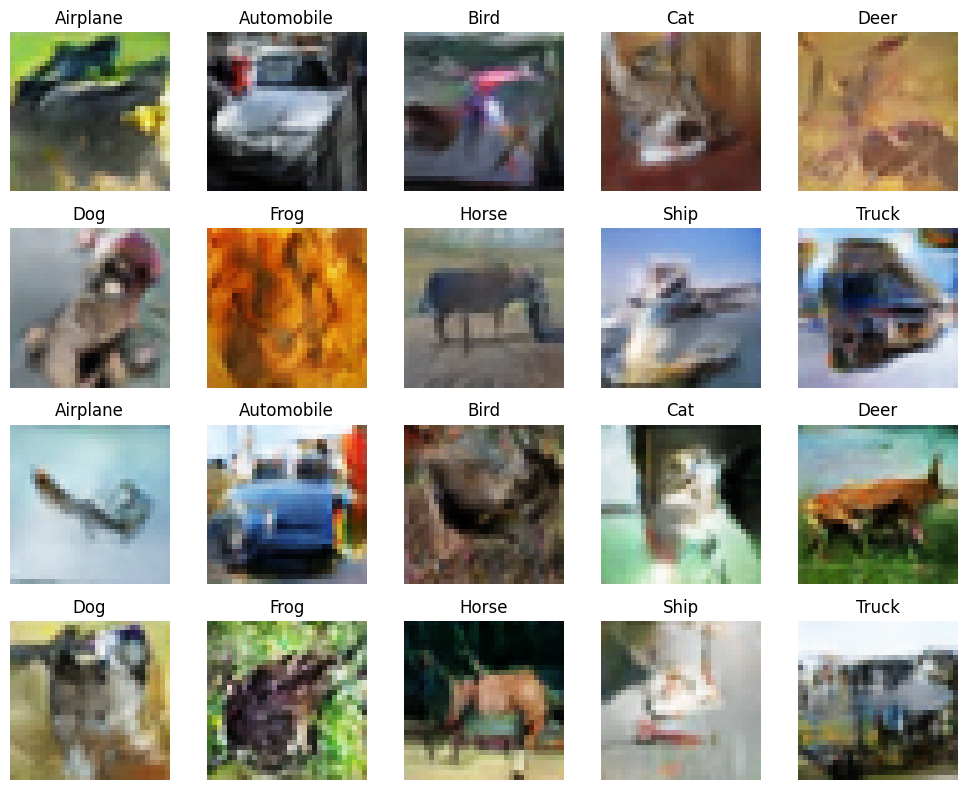

Generator Checkpoint - cGAN/generator-epoch-90.h5
Epoch 91/100
1875/1875 [==============================] - 289s 154ms/step - d_loss: 0.0992 - g_loss: 7.0449 - KL Divergence: 4.5005
Epoch 92/100
1875/1875 [==============================] - 290s 154ms/step - d_loss: 0.0943 - g_loss: 7.1077 - KL Divergence: 4.6322
Epoch 93/100
1875/1875 [==============================] - 282s 150ms/step - d_loss: 0.0926 - g_loss: 7.1482 - KL Divergence: 4.4731
Epoch 94/100
1875/1875 [==============================] - 281s 150ms/step - d_loss: 0.0920 - g_loss: 7.1063 - KL Divergence: 4.7347
Epoch 95/100
1/1 [==============================] - 0s 23ms/step


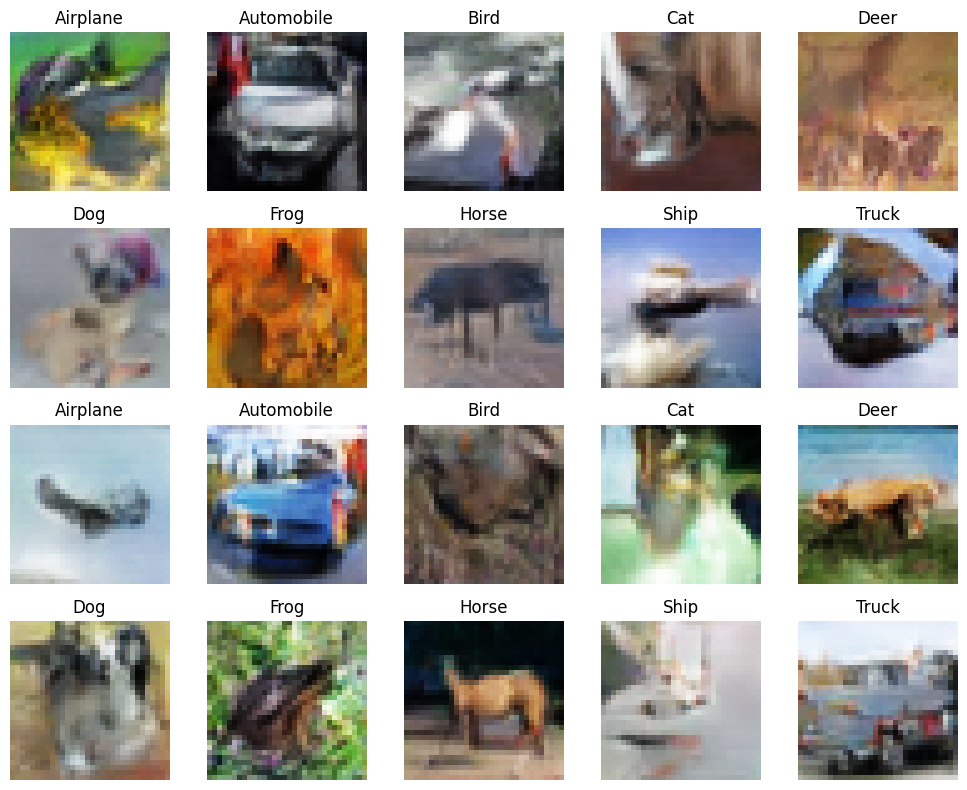

Generator Checkpoint - cGAN/generator-epoch-95.h5
Epoch 96/100
1875/1875 [==============================] - 305s 163ms/step - d_loss: 0.0930 - g_loss: 7.1853 - KL Divergence: 4.4747
Epoch 97/100
1875/1875 [==============================] - 274s 146ms/step - d_loss: 0.0948 - g_loss: 7.1752 - KL Divergence: 4.7670
Epoch 98/100
1875/1875 [==============================] - 273s 145ms/step - d_loss: 0.0911 - g_loss: 7.2463 - KL Divergence: 4.4961
Epoch 99/100
1875/1875 [==============================] - 275s 147ms/step - d_loss: 0.0907 - g_loss: 7.2388 - KL Divergence: 4.7671
Epoch 100/100
1/1 [==============================] - 0s 24ms/step


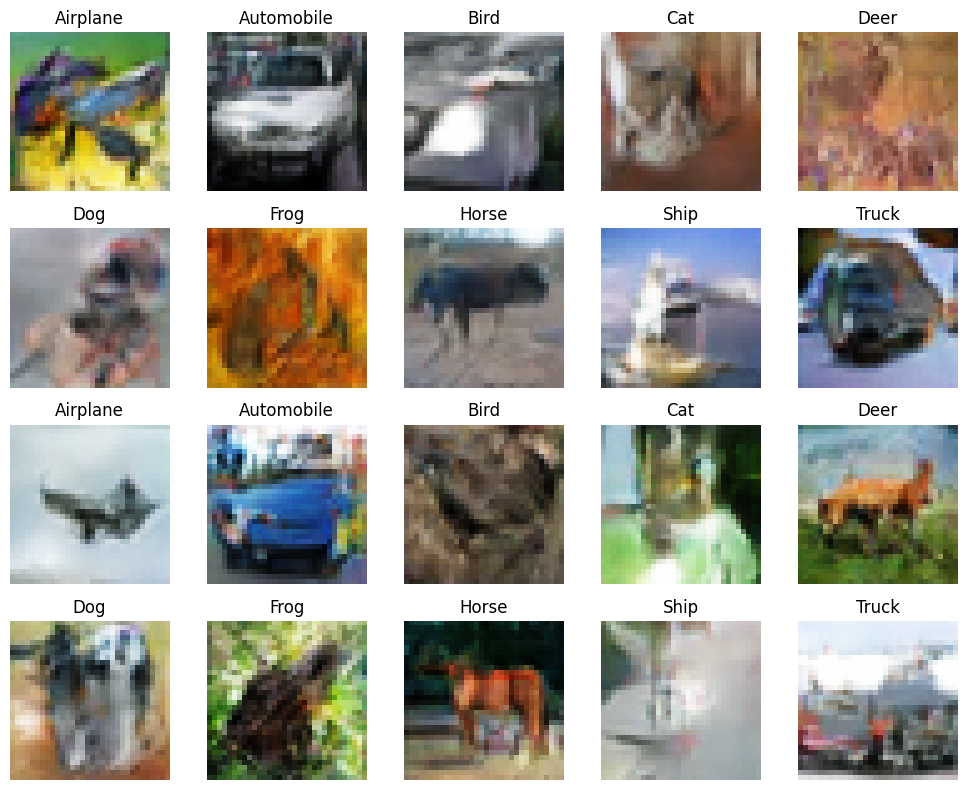

Generator Checkpoint - cGAN/generator-epoch-Full Train.h5


In [15]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(buffer_size=1024).batch(
    64, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

improve_cond_gan_hist = improve_cond_gan.fit(
    dataset, epochs=100, use_multiprocessing=True, workers=16, callbacks=callbacks)

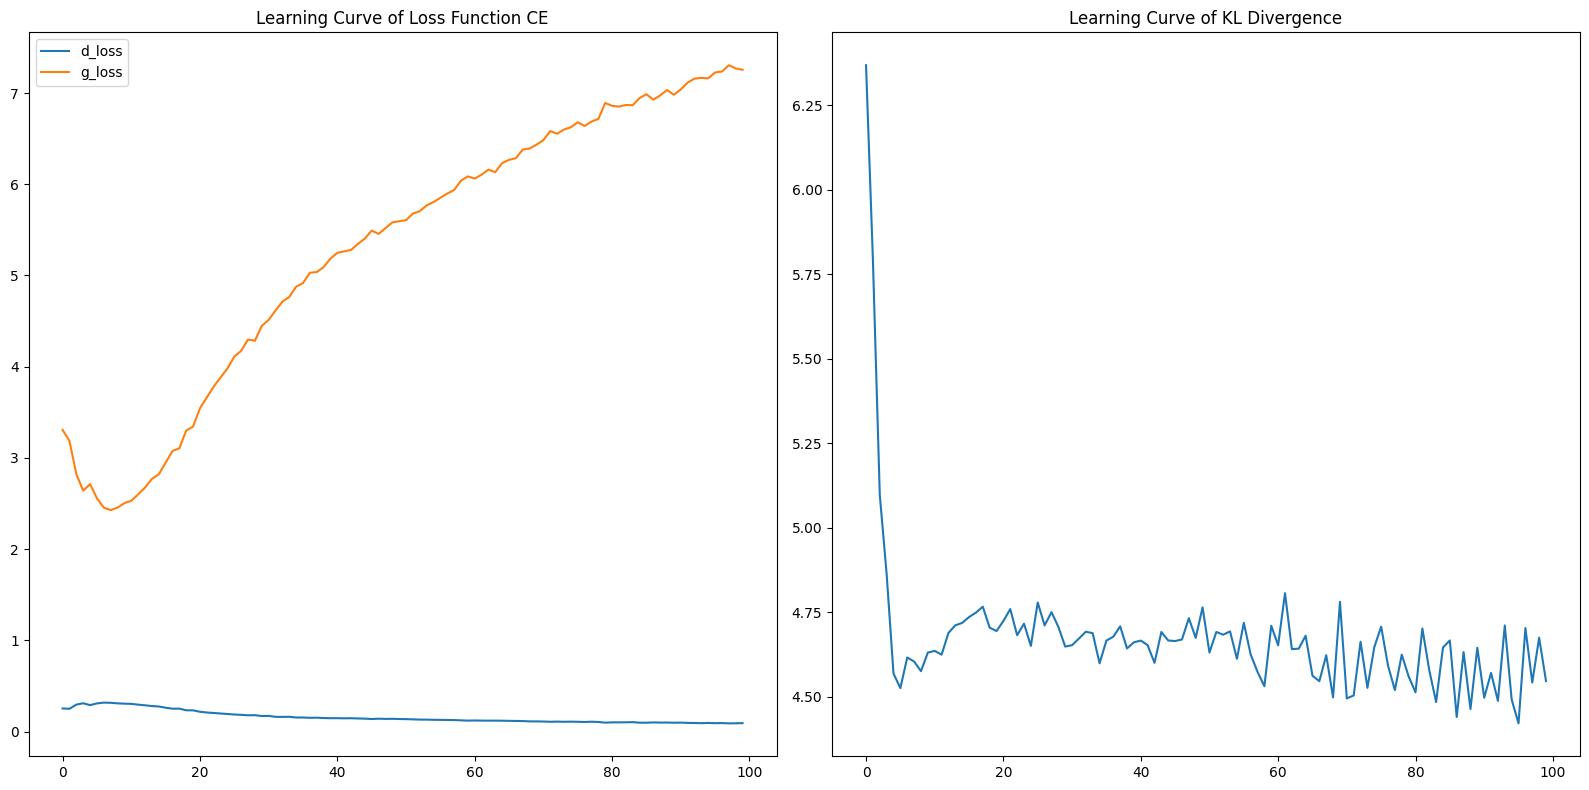

In [16]:
# story history object into dataframe
improve_cond_gan_hist_df = pd.DataFrame(improve_cond_gan_hist.history)

# using pandas dataframe to plot out learning curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), tight_layout=True)
improve_cond_gan_hist_df.loc[:, ["d_loss", 'g_loss']].plot(
    ax=ax1, title=r'Learning Curve of Loss Function CE')
improve_cond_gan_hist_df.loc[:, "KL Divergence"].plot(
    ax=ax2, title="Learning Curve of KL Divergence")
plt.show()

### Loading and Inception Score

In [45]:
# Loading Weights for best Generator
best_epoch = 90
saved_weights = f'cGAN\generator-epoch-{best_epoch}.h5'
improve_cond_gan.generator.load_weights(saved_weights)

In [48]:
n = 1024

# generating labels
labels = np.random.randint(low=0, high=10, size=n)
one_hot_labels = to_categorical(labels)

# Generating 1000 Synthetic Images
random_noise = tf.random.normal(shape=(n, 128))
synthetic_images = improve_cond_gan.generator.predict([random_noise, one_hot_labels])

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)

save_plot(synthetic_images, 4, 32)

for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(class_labels[labels[rand_idx]])
    ax.axis('off')
plt.show()




 1/32 [..............................] - ETA: 1s

32/32 [==============================] - 1s 18ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

313/313 [==============================] - 4s 13ms/step
Latent Vector Dim: (10000, 128)	Generated Images Dim: (10000, 32, 32, 3)


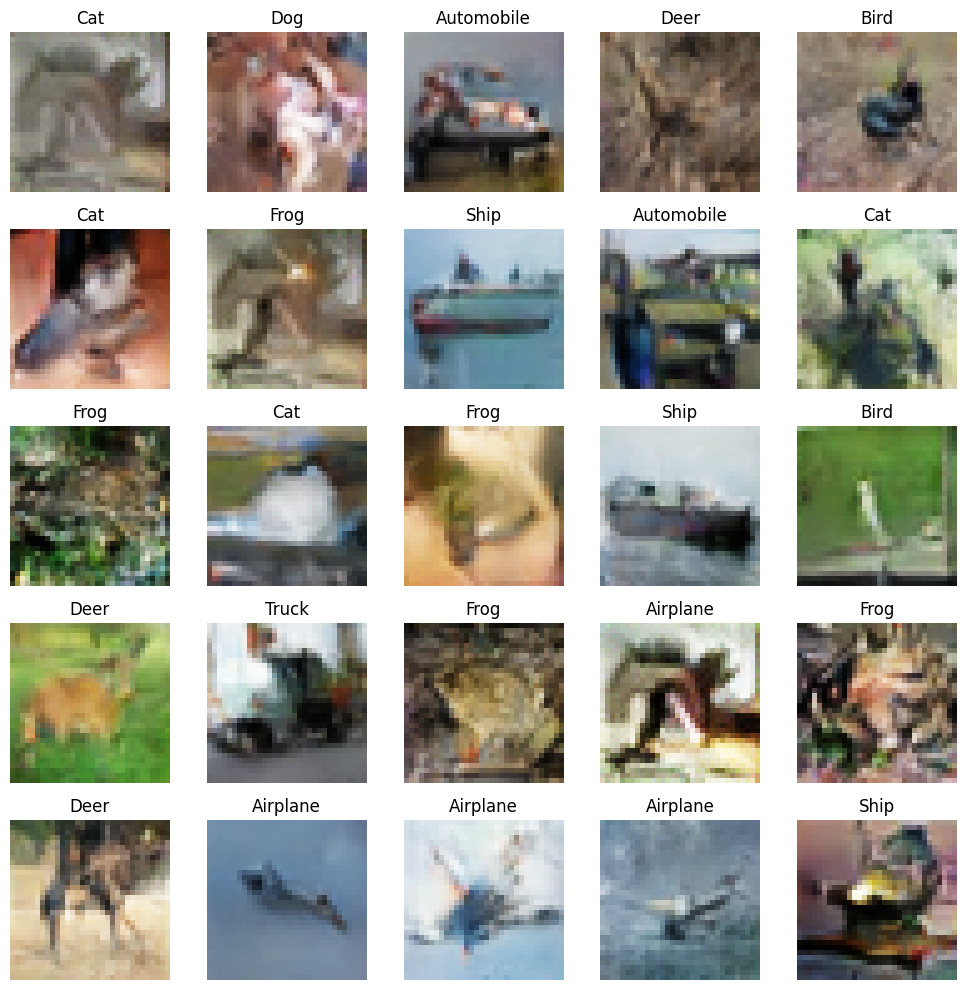

In [19]:
n = 10000

# generating labels
labels = np.random.randint(low=0, high=10, size=n)
one_hot_labels = to_categorical(labels)

# Generating 10000 Synthetic Images
random_noise = tf.random.normal(shape=(n, 128))

synthetic_images = improve_cond_gan.generator.predict(
    [random_noise, one_hot_labels])
print("Latent Vector Dim: {}\tGenerated Images Dim: {}".format(
    random_noise.shape, synthetic_images.shape))

# Scaling back to [0, 1]
synthetic_images -= -1
synthetic_images /= (1 - (-1))

# Display 25 randomly sampled images
fig = plt.figure(figsize=(10, 10), tight_layout=True)
for i in range(25):
    rand_idx = np.random.randint(0, len(synthetic_images))
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(synthetic_images[rand_idx])
    ax.set_title(class_labels[labels[rand_idx]])
    ax.axis('off')
plt.show()

In [21]:
# inception score functions
# inception score

from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
from numpy.random import shuffle
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets import cifar10
from skimage.transform import resize
from numpy import asarray

# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve images
		ix_start, ix_end = i * n_part, (i+1) * n_part
		subset = images[ix_start:ix_end]
		# convert from uint8 to float32
		# subset = subset.astype('float32')
		# scale images to the required size
		subset = scale_images(subset, (299,299,3))
		# pre-process images, scale to [-1,1]
# 		subset = preprocess_input(subset)
		# predict p(y|x)
		p_yx = model.predict(subset)
		# calculate p(y)
		p_y = expand_dims(p_yx.mean(axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = mean(sum_kl_d)
		# undo the log
		is_score = exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = mean(scores), std(scores)
	return is_avg, is_std

In [22]:
# find inception score of 10,000 generated synthetic images
is_avg, is_std = calculate_inception_score(synthetic_images)
print('score', is_avg, is_std)

32/32 [==============================] - 25s 770ms/step
score 5.109746 0.17146139
